# Hourly Data #

In [4]:
# imports
import pandas as pd
import numpy as np
import time

In [5]:
# define data location
#location = '/Users/mithras/Documents/_SCHOOL/_Drexel/BUSN 710 - Capstone/Data/Forecasting Project/'
location = '/Users/loki/Documents/Data/Forecasting Project/'

## Data Cleaning & Checking 

In [6]:
# hourly data
use_jan_in = pd.read_excel(location+'Zip_HourlylUsage_2018.01.xlsx')
use_jul_in = pd.read_excel(location+'Zip_HourlylUsage_2018.07.xlsx')

# daily data
use_oct_in = pd.read_excel(location+'Sample Usage_2017.10 Oct.xlsx')
use_nov_in = pd.read_excel(location+'Sample Usage_2017.11 Nov.xlsx')
use_dec_in = pd.read_excel(location+'Sample Usage_2017.12 Dec.xlsx')
# use_jan_in = pd.read_excel(location+'Sample Usage_2018.01 Jan.xlsx')
use_feb_in = pd.read_excel(location+'Sample Usage_2018.02 Feb.xlsx')
use_mar_in = pd.read_excel(location+'Sample Usage_2018.03 March.xlsx')
use_apr_in = pd.read_excel(location+'Sample Usage_2018.04 April.xlsx')
use_may_in = pd.read_excel(location+'Sample Usage_2018.05 May.xlsx')
use_jun_in = pd.read_excel(location+'Sample Usage_2018.06 June.xlsx')
# use_jul_in = pd.read_excel(location+'Sample Usage_2018.07 Jul.xlsx')
use_aug_in = pd.read_excel(location+'Sample Usage_2018.08 Aug.xlsx')
use_sep_in = pd.read_excel(location+'Sample Usage_2018.09 Sep.xlsx')

# other data
customer_in = pd.read_excel(location+'PECO Zip Customer 2018.10.01 v2.xlsx', sheet_name="Account")
#ratecode_in = pd.read_excel(location+'Rate Codes for Drexel 9_28_2018.xlsx')


In [11]:
# merge use data
daily_in = [use_oct_in, use_nov_in, use_dec_in, use_feb_in, use_mar_in, 
            use_apr_in, use_may_in, use_jun_in, use_aug_in, use_sep_in]
daily = pd.concat(daily_in)
daily = daily.rename(columns={'DAccountID':'DACCOUNTID', 'DMeterNo':'DMETERNO',
                              'DAILY_INTERVAL_USAGE':'Use'})

hourly_in = [use_jan_in, use_jul_in]
hourly = pd.concat(hourly_in)

In [12]:
# create ID tuple
ids = pd.Series(list(map(tuple, daily[['DACCOUNTID', 'DMETERNO']].values)))
daily['ID'] = ids.values

ids = pd.Series(list(map(tuple, hourly[['DACCOUNTID', 'DMETERNO']].values)))
hourly['ID'] = ids.values

ids = pd.Series(list(map(tuple, customer_in[['DACCOUNTID', 'DMETERNO']].values)))
customer_in['ID'] = ids.values

In [13]:
# find gas records
daily = daily.loc[daily['UOM'] == 'CCF']
daily = daily.drop(columns=['UOM'])
hourly = hourly.loc[hourly['UOM'] == 'CCF']
hourly = hourly.drop(columns=['UOM'])

customer = customer_in.drop(columns=['CITY', 'STATE', 'ZIPCODE', 'COUNTYCODE'])

# convert to datetime
daily['Dt'] =  pd.to_datetime(daily['METERREADDATE'])
hourly['Dt'] =  pd.to_datetime(hourly['METERREADDATE'])

## Data Restructuring ##

In [14]:
# functions for naming consistency
def decrement(x, startswith, split):
    """
    decrements a passed string of form "demo#" by 1
    
    Parameters
    ----------
    x : string to be decremented
    split : string to split on

    Returns
    ----------
    y : decremented string
    """
    if x.startswith(startswith):
        a,b = x.split(split)
        b = int(b)-1
        y = a + split + str(b)

        return y

    else:
        return x

    
def interval_to_hour(df):
    """
    function for fast rename/relabel during tidying process
    
    Parameters
    ----------
    df : pandas data frame

    Returns
    ----------
    df : data frame with updated column names
    """
    
    df = df.rename(columns=lambda x: decrement(x, "INTERVAL_", "_"))
    df = df.rename(columns=lambda x: x.replace("INTERVAL_", "HR"))
    return df

In [15]:
# rename for consistency
hourly = interval_to_hour(hourly)
hourly = hourly.drop(columns=['METERREADDATE','HR24'])
daily = daily.drop(columns=['METERREADDATE'])

In [16]:
# Tidy / Stack data (transform into tall data - one row per customer per hour):
# ref: http://www.jeannicholashould.com/tidy-data-in-python.html
tidy_hourly = pd.melt(hourly, 
                      id_vars=['ID','DACCOUNTID','DMETERNO','Dt'],
                      var_name='Hour', value_name='Use')

tidy_hourly_agg = tidy_hourly.groupby(['ID','DACCOUNTID','DMETERNO','Dt']).sum().reset_index()
#tidy_hourly_agg.head()

In [17]:
# join hourly & daily
dfs = [tidy_hourly_agg, daily]
use = pd.concat(dfs, keys=['ID','DACCOUNTID', 'DMETERNO', 'Dt', 'Use'], sort=True).reset_index(drop=True)
#use.head()

In [18]:
# append rate code data
use = use.merge(customer, how='inner', on=['ID','DACCOUNTID','DMETERNO'])
#use.head()

In [19]:
# Add dummy variables for day-of-week
use = use.join(pd.get_dummies(use['Dt'].dt.weekday_name))

# Add dummy variables for holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
dr = pd.date_range(start=min(use['Dt']), end=max(use['Dt']))
holidays = cal.holidays(start=dr.min(), end=dr.max())

use = use.join(pd.get_dummies(use['Dt'].isin(holidays)))
use = use.rename(columns={True:'Holiday'})
use = use.drop(columns=[False])
#use.head()

In [20]:
# sort by date & time
use = use.sort_values(by=["Dt"])

#### Quick look at amount of data we have per ID ####

In [21]:
# drop records with missing data
if len(use) == len(use.dropna(subset=['Use'])):
    print(f'There is no missing data in the {len(use)} rows of useage data')
else:
    use = use.dropna(subset=['Use'])

There is no missing data in the 2279443 rows of useage data


In [22]:
print(f"There are {len(use['DACCOUNTID'].drop_duplicates())} unique AccountIDs in the data")
print(f"There are {len(use['DMETERNO'].drop_duplicates())} unique MeterNos in the data")
ids = use['ID'].drop_duplicates()
print(f"There are {len(ids)} unique AccountID / MeterNo pairs in the data")

There are 6976 unique AccountIDs in the data
There are 6953 unique MeterNos in the data
There are 7097 unique AccountID / MeterNo pairs in the data


In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
ids_to_plot = use.groupby('ID').count()
sns.distplot(ids_to_plot['Use'], bins=20, kde=False, rug=False)
plt.title('Frequency of IDs with X dates')

Text(0.5, 1.0, 'Frequency of IDs with X dates')

Text(0.5, 1.0, 'Frequency of IDs with at least 330 dates')

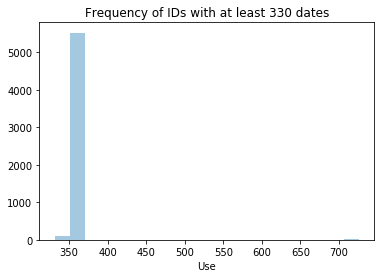

In [24]:
sns.distplot(ids_to_plot[ids_to_plot['Use'] > 330]['Use'], bins=20, kde=False, rug=False)
plt.title('Frequency of IDs with at least 330 dates')

In [ ]:
for i in range(1,365):
    print(f"{ids_to_plot[ids_to_plot['Use'] >= i]['Use'].count()} records have >={i} dates")

#### Find IDs with sufficient data to build initial segments on --> reliable training set ####

In [25]:
# find IDs with at least 360 days of data
sufficient_ids = ids_to_plot[ids_to_plot['Use'] >= 360].reset_index()['ID']
print(f"{100*len(sufficient_ids)/len(use['ID'].unique())} percent of IDs have at least 360 days of data")

76.90573481752854 percent of IDs have at least 360 days of data


In [37]:
# find the dates for which sufficient_ids all have data
pivoted = (use[use['ID'].isin(sufficient_ids)]
           .pivot_table(index='Dt', columns=['ID'], values='Use', fill_value=None))
sufficient_dates = pivoted.dropna().reset_index()['Dt']
print(f"The IDs with sufficient data overlap on {len(sufficient_dates)} days of the most recent year of data")

The IDs with sufficient data overlap on 322 days of the most recent year of data


In [27]:
# filter total use dataset to contain only IDs who have sufficient data and only dates where sufficient_ids have data
sufficient_use = use[(use['ID'].isin(sufficient_ids)) & (use['Dt'].isin(sufficient_dates))]
#sufficient_use.head()

In [38]:
#sanity check
print(len(use))
print(len(sufficient_use))
print(len(ids))
print(len(sufficient_ids))

2279443
1767458
7097
5458


In [35]:
# save file(s) as pickles
# using save location to save with other data files outside of git repo
# data.to_csv(location+'peco.csv', sep='\t')
use.to_pickle(location+'peco_daily.pkl.zip')
sufficient_use.to_pickle(location+'peco_sufficient_daily.pkl.zip')
ids.to_pickle(location+'peco_daily_ids.pkl.zip')
sufficient_ids.to_pickle(location+'peco_sufficient_daily_ids.pkl.zip')

 ### Merge use & weather? ###

In [ ]:
# load data
daily = pd.read_pickle(location+'peco_daily.pkl.zip')
sufficient_daily = pd.read_pickle(location+'peco_sufficient_daily.pkl.zip')
weather = pd.read_pickle(location+'daily_weather.pkl.zip')

# merg
daily = pd.merge(daily, weather, how='inner', on=['Dt'])
sufficient_daily = pd.merge(sufficient_daily, weather, how='inner', on=['Dt'])
# CustIDs || Date | Consumption |||| Weather_variables e

## Archive ##

In [ ]:
# identify unique ids/meterno pairs
def uniqueIDs(dfs, cols):
    """
    Identifies uniques in specified cols and intersects across dfs to return only the overlap
    
    Parameters
    ----------
    dfs : list of pandas data frames with consistent headers
    cols : list of column names to track

    Returns
    ----------
    ids : pandas df with cols columns containing only ids present in all dfs
    """
    
    dfs2 = []
    for df in dfs:
        dfs2.append(df.loc[:, df.columns.isin(cols)].drop_duplicates())
   
    ids = dfs2[0]
    for i in range(1,len(dfs2)):
        ids = pd.merge(ids, dfs2[i], how='inner')
        
    return ids

In [ ]:
# identify unique ids/meterno pairs
daily_ids = uniqueIDs(use,['DACCOUNTID','DMETERNO'])
print(len(daily_ids))
daily_ids.head()
#daily_ids = daily_ids.rename(columns={'DAccountID':'DACCOUNTID', 'DMeterNo':'DMETERNO'})

#hourly_ids = uniqueIDs(hourly_in,['DACCOUNTID','DMETERNO'])

#ids = uniqueIDs([daily_ids,hourly_ids],['DACCOUNTID','DMETERNO'])

In [ ]:
# create year-long list of dates from most recent date in dataset
from datetime import datetime, timedelta
recent = max(use['Dt'])
dates = pd.date_range(start=recent-timedelta(days=364), end=recent).date

# iteratively find intersection between dates of each ID of sufficient length
for i in sufficient_ids:
    id_dates = pd.to_datetime(sufficient_use[(sufficient_use['ID'] == i)]['Dt'].values).date
    dates = set(dates).intersection(id_dates)
    
dates

In [ ]:

from datetime import datetime, timedelta
recent = max(use['Dt'])
dates = pd.date_range(start=recent-timedelta(days=364), end=recent).date

def compareDates(grp_obj):
    dt = pd.to_datetime(grp_obj['Dt'].values).date
    return set(dt).intersection(dates)

sufficient_dates = use[use['ID'].isin(sufficient_ids)].groupby('ID').apply(compareDates)

In [329]:
# find the dates that overlap for sufficient_ids: Find the unique IDs per date, then check if that's all of them

gp = use[use['ID'].isin(sufficient_ids)].groupby('Dt').ID.nunique()
sufficient_dates = gp[gp == use[use['ID'].isin(sufficient_ids)].ID.nunique()].index.tolist()
sufficient_dates = pd.to_datetime(sufficient_dates).date
len(sufficient_dates)

330

In [336]:
bool(set(use['Dt']).intersection(sufficient_dates))
#sufficient_use = use[(use['ID'].isin(sufficient_ids)) && (bool(set(use['Dt']).intersection(sufficient_dates)))]
#sufficient_use.head()

True

In [266]:
#set(pd.to_datetime(use['Dt'].values)).intersection(dates)
pd.to_datetime(use['Dt'].values).date

array([datetime.date(2017, 10, 1), datetime.date(2017, 10, 1),
       datetime.date(2017, 10, 1), ..., datetime.date(2018, 9, 30),
       datetime.date(2018, 9, 30), datetime.date(2018, 9, 30)],
      dtype=object)

In [89]:
# to find records with full year, map each (AccountID,MeterNo) pair to a year of most-recent dates
from datetime import datetime, timedelta
recent = max(use['Dt'])
recent_year = pd.date_range(start=recent-timedelta(days=364), end=recent).date

There are 365 days of data in the most recent year of data


In [301]:
#id_dates = use.loc[(use['DACCOUNTID'] == ids.values[0,0]) & (use['DMETERNO'] == ids.values[0,1])]['Dt'].values
#id_dates = pd.to_datetime(id_dates).date
#set(recent_year).issubset(id_dates)
bool(set(recent_year).intersection(id_dates))

#set(recent_year).issubset(set(use['Dt'].drop_duplicates()))

True

In [276]:
#for row in sufficient_ids.itertuples():
#    print(sufficient_use[(sufficient_use['ID'] == row[0])])

        DACCOUNTID_x     DMETERNO_x       Dt_x                             ID  \
904701  665128346596  4464578359312 2017-10-01  (665128346596, 4464578359312)   
904702  665128346596  4464578359312 2017-10-02  (665128346596, 4464578359312)   
904703  665128346596  4464578359312 2017-10-03  (665128346596, 4464578359312)   
904704  665128346596  4464578359312 2017-10-04  (665128346596, 4464578359312)   
904705  665128346596  4464578359312 2017-10-05  (665128346596, 4464578359312)   
904706  665128346596  4464578359312 2017-10-06  (665128346596, 4464578359312)   
904707  665128346596  4464578359312 2017-10-07  (665128346596, 4464578359312)   
904708  665128346596  4464578359312 2017-10-08  (665128346596, 4464578359312)   
904709  665128346596  4464578359312 2017-10-09  (665128346596, 4464578359312)   
904710  665128346596  4464578359312 2017-10-10  (665128346596, 4464578359312)   
904711  665128346596  4464578359312 2017-10-11  (665128346596, 4464578359312)   
904712  665128346596  446457

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
1974432  819288717920  4465122076620 2017-10-03   
1974433  819288717920  4465122076620 2017-10-04   
1974434  819288717920  4465122076620 2017-10-05   
1974435  819288717920  4465122076620 2017-10-06   
1974436  819288717920  4465122076620 2017-10-07   
1974437  819288717920  4465122076620 2017-10-08   
1974438  819288717920  4465122076620 2017-10-09   
1974439  819288717920  4465122076620 2017-10-10   
1974440  819288717920  4465122076620 2017-10-11   
1974441  819288717920  4465122076620 2017-10-12   
1974442  819288717920  4465122076620 2017-10-13   
1974443  819288717920  4465122076620 2017-10-14   
1974444  819288717920  4465122076620 2017-10-15   
1974445  819288717920  4465122076620 2017-10-16   
1974446  819288717920  4465122076620 2017-10-17   
1974447  819288717920  4465122076620 2017-10-18   
1974448  819288717920  4465122076620 2017-10-19   
1974449  819288717920  4465122076620 2017-10-20   
1974450  819288717920  44651220

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1155142  1284453836940  4464330738752 2017-10-01   
1155143  1284453836940  4464330738752 2017-10-02   
1155144  1284453836940  4464330738752 2017-10-03   
1155145  1284453836940  4464330738752 2017-10-04   
1155146  1284453836940  4464330738752 2017-10-05   
1155147  1284453836940  4464330738752 2017-10-06   
1155148  1284453836940  4464330738752 2017-10-07   
1155149  1284453836940  4464330738752 2017-10-08   
1155150  1284453836940  4464330738752 2017-10-09   
1155151  1284453836940  4464330738752 2017-10-10   
1155152  1284453836940  4464330738752 2017-10-11   
1155153  1284453836940  4464330738752 2017-10-12   
1155154  1284453836940  4464330738752 2017-10-13   
1155155  1284453836940  4464330738752 2017-10-14   
1155156  1284453836940  4464330738752 2017-10-15   
1155157  1284453836940  4464330738752 2017-10-16   
1155158  1284453836940  4464330738752 2017-10-17   
1155159  1284453836940  4464330738752 2017-10-18   
1155160  128

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
225453  1475598667620  4968015331728 2017-10-01   
225454  1475598667620  4968015331728 2017-10-02   
225455  1475598667620  4968015331728 2017-10-03   
225456  1475598667620  4968015331728 2017-10-04   
225457  1475598667620  4968015331728 2017-10-05   
225458  1475598667620  4968015331728 2017-10-06   
225459  1475598667620  4968015331728 2017-10-07   
225460  1475598667620  4968015331728 2017-10-08   
225461  1475598667620  4968015331728 2017-10-09   
225462  1475598667620  4968015331728 2017-10-10   
225463  1475598667620  4968015331728 2017-10-11   
225464  1475598667620  4968015331728 2017-10-12   
225465  1475598667620  4968015331728 2017-10-13   
225466  1475598667620  4968015331728 2017-10-14   
225467  1475598667620  4968015331728 2017-10-15   
225468  1475598667620  4968015331728 2017-10-16   
225469  1475598667620  4968015331728 2017-10-17   
225470  1475598667620  4968015331728 2017-10-18   
225471  1475598667620  49680153

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1177582  1633677808960  4465140978064 2017-10-01   
1177583  1633677808960  4465140978064 2017-10-02   
1177584  1633677808960  4465140978064 2017-10-03   
1177585  1633677808960  4465140978064 2017-10-04   
1177586  1633677808960  4465140978064 2017-10-05   
1177587  1633677808960  4465140978064 2017-10-06   
1177588  1633677808960  4465140978064 2017-10-07   
1177589  1633677808960  4465140978064 2017-10-08   
1177590  1633677808960  4465140978064 2017-10-09   
1177591  1633677808960  4465140978064 2017-10-10   
1177592  1633677808960  4465140978064 2017-10-11   
1177593  1633677808960  4465140978064 2017-10-12   
1177594  1633677808960  4465140978064 2017-10-13   
1177595  1633677808960  4465140978064 2017-10-14   
1177596  1633677808960  4465140978064 2017-10-15   
1177597  1633677808960  4465140978064 2017-10-16   
1177598  1633677808960  4465140978064 2017-10-17   
1177599  1633677808960  4465140978064 2017-10-18   
1177600  163

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
306531  2797028308840  608187028524 2017-10-01  (2797028308840, 608187028524)   
306532  2797028308840  608187028524 2017-10-02  (2797028308840, 608187028524)   
306533  2797028308840  608187028524 2017-10-03  (2797028308840, 608187028524)   
306534  2797028308840  608187028524 2017-10-04  (2797028308840, 608187028524)   
306535  2797028308840  608187028524 2017-10-05  (2797028308840, 608187028524)   
306536  2797028308840  608187028524 2017-10-06  (2797028308840, 608187028524)   
306537  2797028308840  608187028524 2017-10-07  (2797028308840, 608187028524)   
306538  2797028308840  608187028524 2017-10-08  (2797028308840, 608187028524)   
306539  2797028308840  608187028524 2017-10-09  (2797028308840, 608187028524)   
306540  2797028308840  608187028524 2017-10-10  (2797028308840, 608187028524)   
306541  2797028308840  608187028524 2017-10-11  (2797028308840, 608187028524)   
306542  2797028308840  60818

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
415455  3147700007272  4464576341088 2017-10-01   
415456  3147700007272  4464576341088 2017-10-02   
415457  3147700007272  4464576341088 2017-10-03   
415458  3147700007272  4464576341088 2017-10-04   
415459  3147700007272  4464576341088 2017-10-05   
415460  3147700007272  4464576341088 2017-10-06   
415461  3147700007272  4464576341088 2017-10-07   
415462  3147700007272  4464576341088 2017-10-08   
415463  3147700007272  4464576341088 2017-10-09   
415464  3147700007272  4464576341088 2017-10-10   
415465  3147700007272  4464576341088 2017-10-11   
415466  3147700007272  4464576341088 2017-10-12   
415467  3147700007272  4464576341088 2017-10-13   
415468  3147700007272  4464576341088 2017-10-14   
415469  3147700007272  4464576341088 2017-10-15   
415470  3147700007272  4464576341088 2017-10-16   
415471  3147700007272  4464576341088 2017-10-17   
415472  3147700007272  4464576341088 2017-10-18   
415473  3147700007272  44645763

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
395195  3226067800440  4465120989884 2017-10-01   
395196  3226067800440  4465120989884 2017-10-02   
395197  3226067800440  4465120989884 2017-10-03   
395198  3226067800440  4465120989884 2017-10-04   
395199  3226067800440  4465120989884 2017-10-05   
395200  3226067800440  4465120989884 2017-10-06   
395201  3226067800440  4465120989884 2017-10-07   
395202  3226067800440  4465120989884 2017-10-08   
395203  3226067800440  4465120989884 2017-10-09   
395204  3226067800440  4465120989884 2017-10-10   
395205  3226067800440  4465120989884 2017-10-11   
395206  3226067800440  4465120989884 2017-10-12   
395207  3226067800440  4465120989884 2017-10-13   
395208  3226067800440  4465120989884 2017-10-14   
395209  3226067800440  4465120989884 2017-10-15   
395210  3226067800440  4465120989884 2017-10-16   
395211  3226067800440  4465120989884 2017-10-17   
395212  3226067800440  4465120989884 2017-10-18   
395213  3226067800440  44651209

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
750183  3610105903588  792542825352 2017-10-01  (3610105903588, 792542825352)   
750184  3610105903588  792542825352 2017-10-02  (3610105903588, 792542825352)   
750185  3610105903588  792542825352 2017-10-03  (3610105903588, 792542825352)   
750186  3610105903588  792542825352 2017-10-04  (3610105903588, 792542825352)   
750187  3610105903588  792542825352 2017-10-05  (3610105903588, 792542825352)   
750188  3610105903588  792542825352 2017-10-06  (3610105903588, 792542825352)   
750189  3610105903588  792542825352 2017-10-07  (3610105903588, 792542825352)   
750190  3610105903588  792542825352 2017-10-08  (3610105903588, 792542825352)   
750191  3610105903588  792542825352 2017-10-09  (3610105903588, 792542825352)   
750192  3610105903588  792542825352 2017-10-10  (3610105903588, 792542825352)   
750193  3610105903588  792542825352 2017-10-11  (3610105903588, 792542825352)   
750194  3610105903588  79254

        DACCOUNTID_x     DMETERNO_x       Dt_x  \
48854  4389836732492  4465140551132 2017-10-01   
48855  4389836732492  4465140551132 2017-10-02   
48856  4389836732492  4465140551132 2017-10-03   
48857  4389836732492  4465140551132 2017-10-04   
48858  4389836732492  4465140551132 2017-10-05   
48859  4389836732492  4465140551132 2017-10-06   
48860  4389836732492  4465140551132 2017-10-07   
48861  4389836732492  4465140551132 2017-10-08   
48862  4389836732492  4465140551132 2017-10-09   
48863  4389836732492  4465140551132 2017-10-10   
48864  4389836732492  4465140551132 2017-10-11   
48865  4389836732492  4465140551132 2017-10-12   
48866  4389836732492  4465140551132 2017-10-13   
48867  4389836732492  4465140551132 2017-10-14   
48868  4389836732492  4465140551132 2017-10-15   
48869  4389836732492  4465140551132 2017-10-16   
48870  4389836732492  4465140551132 2017-10-17   
48871  4389836732492  4465140551132 2017-10-18   
48872  4389836732492  4465140551132 2017-10-19   


          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1616532  4929206863620  4968050534212 2017-10-01   
1616533  4929206863620  4968050534212 2017-10-02   
1616534  4929206863620  4968050534212 2017-10-03   
1616535  4929206863620  4968050534212 2017-10-04   
1616536  4929206863620  4968050534212 2017-10-05   
1616537  4929206863620  4968050534212 2017-10-06   
1616538  4929206863620  4968050534212 2017-10-07   
1616539  4929206863620  4968050534212 2017-10-08   
1616540  4929206863620  4968050534212 2017-10-09   
1616541  4929206863620  4968050534212 2017-10-10   
1616542  4929206863620  4968050534212 2017-10-11   
1616543  4929206863620  4968050534212 2017-10-12   
1616544  4929206863620  4968050534212 2017-10-13   
1616545  4929206863620  4968050534212 2017-10-14   
1616546  4929206863620  4968050534212 2017-10-15   
1616547  4929206863620  4968050534212 2017-10-16   
1616548  4929206863620  4968050534212 2017-10-17   
1616549  4929206863620  4968050534212 2017-10-18   
1616550  492

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
318112  5013159703588  4968030429596 2017-10-01   
318113  5013159703588  4968030429596 2017-10-02   
318114  5013159703588  4968030429596 2017-10-03   
318115  5013159703588  4968030429596 2017-10-04   
318116  5013159703588  4968030429596 2017-10-05   
318117  5013159703588  4968030429596 2017-10-06   
318118  5013159703588  4968030429596 2017-10-07   
318119  5013159703588  4968030429596 2017-10-08   
318120  5013159703588  4968030429596 2017-10-09   
318121  5013159703588  4968030429596 2017-10-10   
318122  5013159703588  4968030429596 2017-10-11   
318123  5013159703588  4968030429596 2017-10-12   
318124  5013159703588  4968030429596 2017-10-13   
318125  5013159703588  4968030429596 2017-10-14   
318126  5013159703588  4968030429596 2017-10-15   
318127  5013159703588  4968030429596 2017-10-16   
318128  5013159703588  4968030429596 2017-10-17   
318129  5013159703588  4968030429596 2017-10-18   
318130  5013159703588  49680304

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1944762  6365209412404  606237967508 2017-10-01   
1944763  6365209412404  606237967508 2017-10-02   
1944764  6365209412404  606237967508 2017-10-03   
1944765  6365209412404  606237967508 2017-10-04   
1944766  6365209412404  606237967508 2017-10-05   
1944767  6365209412404  606237967508 2017-10-06   
1944768  6365209412404  606237967508 2017-10-07   
1944769  6365209412404  606237967508 2017-10-08   
1944770  6365209412404  606237967508 2017-10-09   
1944771  6365209412404  606237967508 2017-10-10   
1944772  6365209412404  606237967508 2017-10-11   
1944773  6365209412404  606237967508 2017-10-12   
1944774  6365209412404  606237967508 2017-10-13   
1944775  6365209412404  606237967508 2017-10-14   
1944776  6365209412404  606237967508 2017-10-15   
1944777  6365209412404  606237967508 2017-10-16   
1944778  6365209412404  606237967508 2017-10-17   
1944779  6365209412404  606237967508 2017-10-18   
1944780  6365209412404  6062379

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1160571  6986179755308  732577431488 2017-10-01   
1160572  6986179755308  732577431488 2017-10-02   
1160573  6986179755308  732577431488 2017-10-03   
1160574  6986179755308  732577431488 2017-10-04   
1160575  6986179755308  732577431488 2017-10-05   
1160576  6986179755308  732577431488 2017-10-06   
1160577  6986179755308  732577431488 2017-10-07   
1160578  6986179755308  732577431488 2017-10-08   
1160579  6986179755308  732577431488 2017-10-09   
1160580  6986179755308  732577431488 2017-10-10   
1160581  6986179755308  732577431488 2017-10-11   
1160582  6986179755308  732577431488 2017-10-12   
1160583  6986179755308  732577431488 2017-10-13   
1160584  6986179755308  732577431488 2017-10-14   
1160585  6986179755308  732577431488 2017-10-15   
1160586  6986179755308  732577431488 2017-10-16   
1160587  6986179755308  732577431488 2017-10-17   
1160588  6986179755308  732577431488 2017-10-18   
1160589  6986179755308  7325774

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1642591  6986191166036  756635282560 2017-10-01   
1642592  6986191166036  756635282560 2017-10-02   
1642593  6986191166036  756635282560 2017-10-03   
1642594  6986191166036  756635282560 2017-10-04   
1642595  6986191166036  756635282560 2017-10-05   
1642596  6986191166036  756635282560 2017-10-06   
1642597  6986191166036  756635282560 2017-10-07   
1642598  6986191166036  756635282560 2017-10-08   
1642599  6986191166036  756635282560 2017-10-09   
1642600  6986191166036  756635282560 2017-10-10   
1642601  6986191166036  756635282560 2017-10-11   
1642602  6986191166036  756635282560 2017-10-12   
1642603  6986191166036  756635282560 2017-10-13   
1642604  6986191166036  756635282560 2017-10-14   
1642605  6986191166036  756635282560 2017-10-15   
1642606  6986191166036  756635282560 2017-10-16   
1642607  6986191166036  756635282560 2017-10-17   
1642608  6986191166036  756635282560 2017-10-18   
1642609  6986191166036  7566352

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
319198  6987868737112  608973592516 2017-10-01  (6987868737112, 608973592516)   
319199  6987868737112  608973592516 2017-10-02  (6987868737112, 608973592516)   
319200  6987868737112  608973592516 2017-10-03  (6987868737112, 608973592516)   
319201  6987868737112  608973592516 2017-10-04  (6987868737112, 608973592516)   
319202  6987868737112  608973592516 2017-10-05  (6987868737112, 608973592516)   
319203  6987868737112  608973592516 2017-10-06  (6987868737112, 608973592516)   
319204  6987868737112  608973592516 2017-10-07  (6987868737112, 608973592516)   
319205  6987868737112  608973592516 2017-10-08  (6987868737112, 608973592516)   
319206  6987868737112  608973592516 2017-10-09  (6987868737112, 608973592516)   
319207  6987868737112  608973592516 2017-10-10  (6987868737112, 608973592516)   
319208  6987868737112  608973592516 2017-10-11  (6987868737112, 608973592516)   
319209  6987868737112  60897

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
808802  7008791937004  810112978940 2017-10-01  (7008791937004, 810112978940)   
808803  7008791937004  810112978940 2017-10-02  (7008791937004, 810112978940)   
808804  7008791937004  810112978940 2017-10-03  (7008791937004, 810112978940)   
808805  7008791937004  810112978940 2017-10-04  (7008791937004, 810112978940)   
808806  7008791937004  810112978940 2017-10-05  (7008791937004, 810112978940)   
808807  7008791937004  810112978940 2017-10-06  (7008791937004, 810112978940)   
808808  7008791937004  810112978940 2017-10-07  (7008791937004, 810112978940)   
808809  7008791937004  810112978940 2017-10-08  (7008791937004, 810112978940)   
808810  7008791937004  810112978940 2017-10-09  (7008791937004, 810112978940)   
808811  7008791937004  810112978940 2017-10-10  (7008791937004, 810112978940)   
808812  7008791937004  810112978940 2017-10-11  (7008791937004, 810112978940)   
808813  7008791937004  81011

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
341995  7017267818000  608974446380 2017-10-01  (7017267818000, 608974446380)   
341996  7017267818000  608974446380 2017-10-02  (7017267818000, 608974446380)   
341997  7017267818000  608974446380 2017-10-03  (7017267818000, 608974446380)   
341998  7017267818000  608974446380 2017-10-04  (7017267818000, 608974446380)   
341999  7017267818000  608974446380 2017-10-05  (7017267818000, 608974446380)   
342000  7017267818000  608974446380 2017-10-06  (7017267818000, 608974446380)   
342001  7017267818000  608974446380 2017-10-07  (7017267818000, 608974446380)   
342002  7017267818000  608974446380 2017-10-08  (7017267818000, 608974446380)   
342003  7017267818000  608974446380 2017-10-09  (7017267818000, 608974446380)   
342004  7017267818000  608974446380 2017-10-10  (7017267818000, 608974446380)   
342005  7017267818000  608974446380 2017-10-11  (7017267818000, 608974446380)   
342006  7017267818000  60897

        DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
94094  7017275813272  636224351580 2017-10-01  (7017275813272, 636224351580)   
94095  7017275813272  636224351580 2017-10-02  (7017275813272, 636224351580)   
94096  7017275813272  636224351580 2017-10-03  (7017275813272, 636224351580)   
94097  7017275813272  636224351580 2017-10-04  (7017275813272, 636224351580)   
94098  7017275813272  636224351580 2017-10-05  (7017275813272, 636224351580)   
94099  7017275813272  636224351580 2017-10-06  (7017275813272, 636224351580)   
94100  7017275813272  636224351580 2017-10-07  (7017275813272, 636224351580)   
94101  7017275813272  636224351580 2017-10-08  (7017275813272, 636224351580)   
94102  7017275813272  636224351580 2017-10-09  (7017275813272, 636224351580)   
94103  7017275813272  636224351580 2017-10-10  (7017275813272, 636224351580)   
94104  7017275813272  636224351580 2017-10-11  (7017275813272, 636224351580)   
94105  7017275813272  636224351580 2017-

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1387833  7021122004848  636450159796 2017-10-01   
1387834  7021122004848  636450159796 2017-10-02   
1387835  7021122004848  636450159796 2017-10-03   
1387836  7021122004848  636450159796 2017-10-04   
1387837  7021122004848  636450159796 2017-10-05   
1387838  7021122004848  636450159796 2017-10-06   
1387839  7021122004848  636450159796 2017-10-07   
1387840  7021122004848  636450159796 2017-10-08   
1387841  7021122004848  636450159796 2017-10-09   
1387842  7021122004848  636450159796 2017-10-10   
1387843  7021122004848  636450159796 2017-10-11   
1387844  7021122004848  636450159796 2017-10-12   
1387845  7021122004848  636450159796 2017-10-13   
1387846  7021122004848  636450159796 2017-10-14   
1387847  7021122004848  636450159796 2017-10-15   
1387848  7021122004848  636450159796 2017-10-16   
1387849  7021122004848  636450159796 2017-10-17   
1387850  7021122004848  636450159796 2017-10-18   
1387851  7021122004848  6364501

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
140406  7044444252084  610169855980 2017-10-01  (7044444252084, 610169855980)   
140407  7044444252084  610169855980 2017-10-02  (7044444252084, 610169855980)   
140408  7044444252084  610169855980 2017-10-03  (7044444252084, 610169855980)   
140409  7044444252084  610169855980 2017-10-04  (7044444252084, 610169855980)   
140410  7044444252084  610169855980 2017-10-05  (7044444252084, 610169855980)   
140411  7044444252084  610169855980 2017-10-06  (7044444252084, 610169855980)   
140412  7044444252084  610169855980 2017-10-07  (7044444252084, 610169855980)   
140413  7044444252084  610169855980 2017-10-08  (7044444252084, 610169855980)   
140414  7044444252084  610169855980 2017-10-09  (7044444252084, 610169855980)   
140415  7044444252084  610169855980 2017-10-10  (7044444252084, 610169855980)   
140416  7044444252084  610169855980 2017-10-11  (7044444252084, 610169855980)   
140417  7044444252084  61016

        DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
47043  7048309849660  637035250696 2017-10-01  (7048309849660, 637035250696)   
47044  7048309849660  637035250696 2017-10-02  (7048309849660, 637035250696)   
47045  7048309849660  637035250696 2017-10-03  (7048309849660, 637035250696)   
47046  7048309849660  637035250696 2017-10-04  (7048309849660, 637035250696)   
47047  7048309849660  637035250696 2017-10-05  (7048309849660, 637035250696)   
47048  7048309849660  637035250696 2017-10-06  (7048309849660, 637035250696)   
47049  7048309849660  637035250696 2017-10-07  (7048309849660, 637035250696)   
47050  7048309849660  637035250696 2017-10-08  (7048309849660, 637035250696)   
47051  7048309849660  637035250696 2017-10-09  (7048309849660, 637035250696)   
47052  7048309849660  637035250696 2017-10-10  (7048309849660, 637035250696)   
47053  7048309849660  637035250696 2017-10-11  (7048309849660, 637035250696)   
47054  7048309849660  637035250696 2017-

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1647295  7063830613212  640057890444 2017-10-01   
1647296  7063830613212  640057890444 2017-10-02   
1647297  7063830613212  640057890444 2017-10-03   
1647298  7063830613212  640057890444 2017-10-04   
1647299  7063830613212  640057890444 2017-10-05   
1647300  7063830613212  640057890444 2017-10-06   
1647301  7063830613212  640057890444 2017-10-07   
1647302  7063830613212  640057890444 2017-10-08   
1647303  7063830613212  640057890444 2017-10-09   
1647304  7063830613212  640057890444 2017-10-10   
1647305  7063830613212  640057890444 2017-10-11   
1647306  7063830613212  640057890444 2017-10-12   
1647307  7063830613212  640057890444 2017-10-13   
1647308  7063830613212  640057890444 2017-10-14   
1647309  7063830613212  640057890444 2017-10-15   
1647310  7063830613212  640057890444 2017-10-16   
1647311  7063830613212  640057890444 2017-10-17   
1647312  7063830613212  640057890444 2017-10-18   
1647313  7063830613212  6400578

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
378184  7075443318860  731681417656 2017-10-01  (7075443318860, 731681417656)   
378185  7075443318860  731681417656 2017-10-02  (7075443318860, 731681417656)   
378186  7075443318860  731681417656 2017-10-03  (7075443318860, 731681417656)   
378187  7075443318860  731681417656 2017-10-04  (7075443318860, 731681417656)   
378188  7075443318860  731681417656 2017-10-05  (7075443318860, 731681417656)   
378189  7075443318860  731681417656 2017-10-06  (7075443318860, 731681417656)   
378190  7075443318860  731681417656 2017-10-07  (7075443318860, 731681417656)   
378191  7075443318860  731681417656 2017-10-08  (7075443318860, 731681417656)   
378192  7075443318860  731681417656 2017-10-09  (7075443318860, 731681417656)   
378193  7075443318860  731681417656 2017-10-10  (7075443318860, 731681417656)   
378194  7075443318860  731681417656 2017-10-11  (7075443318860, 731681417656)   
378195  7075443318860  73168

        DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
47405  7076476610736  730586919256 2017-10-01  (7076476610736, 730586919256)   
47406  7076476610736  730586919256 2017-10-02  (7076476610736, 730586919256)   
47407  7076476610736  730586919256 2017-10-03  (7076476610736, 730586919256)   
47408  7076476610736  730586919256 2017-10-04  (7076476610736, 730586919256)   
47409  7076476610736  730586919256 2017-10-05  (7076476610736, 730586919256)   
47410  7076476610736  730586919256 2017-10-06  (7076476610736, 730586919256)   
47411  7076476610736  730586919256 2017-10-07  (7076476610736, 730586919256)   
47412  7076476610736  730586919256 2017-10-08  (7076476610736, 730586919256)   
47413  7076476610736  730586919256 2017-10-09  (7076476610736, 730586919256)   
47414  7076476610736  730586919256 2017-10-10  (7076476610736, 730586919256)   
47415  7076476610736  730586919256 2017-10-11  (7076476610736, 730586919256)   
47416  7076476610736  730586919256 2017-

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
691563  7079324480048  606738370624 2017-10-01  (7079324480048, 606738370624)   
691564  7079324480048  606738370624 2017-10-02  (7079324480048, 606738370624)   
691565  7079324480048  606738370624 2017-10-03  (7079324480048, 606738370624)   
691566  7079324480048  606738370624 2017-10-04  (7079324480048, 606738370624)   
691567  7079324480048  606738370624 2017-10-05  (7079324480048, 606738370624)   
691568  7079324480048  606738370624 2017-10-06  (7079324480048, 606738370624)   
691569  7079324480048  606738370624 2017-10-07  (7079324480048, 606738370624)   
691570  7079324480048  606738370624 2017-10-08  (7079324480048, 606738370624)   
691571  7079324480048  606738370624 2017-10-09  (7079324480048, 606738370624)   
691572  7079324480048  606738370624 2017-10-10  (7079324480048, 606738370624)   
691573  7079324480048  606738370624 2017-10-11  (7079324480048, 606738370624)   
691574  7079324480048  60673

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1790959  7079340043660  726830072904 2017-10-01   
1790960  7079340043660  726830072904 2017-10-02   
1790961  7079340043660  726830072904 2017-10-03   
1790962  7079340043660  726830072904 2017-10-04   
1790963  7079340043660  726830072904 2017-10-05   
1790964  7079340043660  726830072904 2017-10-06   
1790965  7079340043660  726830072904 2017-10-07   
1790966  7079340043660  726830072904 2017-10-08   
1790967  7079340043660  726830072904 2017-10-09   
1790968  7079340043660  726830072904 2017-10-10   
1790969  7079340043660  726830072904 2017-10-11   
1790970  7079340043660  726830072904 2017-10-12   
1790971  7079340043660  726830072904 2017-10-13   
1790972  7079340043660  726830072904 2017-10-14   
1790973  7079340043660  726830072904 2017-10-15   
1790974  7079340043660  726830072904 2017-10-16   
1790975  7079340043660  726830072904 2017-10-17   
1790976  7079340043660  726830072904 2017-10-18   
1790977  7079340043660  7268300

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
188542  7092039756992  732147122844 2017-10-01  (7092039756992, 732147122844)   
188543  7092039756992  732147122844 2017-10-02  (7092039756992, 732147122844)   
188544  7092039756992  732147122844 2017-10-03  (7092039756992, 732147122844)   
188545  7092039756992  732147122844 2017-10-04  (7092039756992, 732147122844)   
188546  7092039756992  732147122844 2017-10-05  (7092039756992, 732147122844)   
188547  7092039756992  732147122844 2017-10-06  (7092039756992, 732147122844)   
188548  7092039756992  732147122844 2017-10-07  (7092039756992, 732147122844)   
188549  7092039756992  732147122844 2017-10-08  (7092039756992, 732147122844)   
188550  7092039756992  732147122844 2017-10-09  (7092039756992, 732147122844)   
188551  7092039756992  732147122844 2017-10-10  (7092039756992, 732147122844)   
188552  7092039756992  732147122844 2017-10-11  (7092039756992, 732147122844)   
188553  7092039756992  73214

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
568893  7098718875260  731159784376 2017-10-01  (7098718875260, 731159784376)   
568894  7098718875260  731159784376 2017-10-02  (7098718875260, 731159784376)   
568895  7098718875260  731159784376 2017-10-03  (7098718875260, 731159784376)   
568896  7098718875260  731159784376 2017-10-04  (7098718875260, 731159784376)   
568897  7098718875260  731159784376 2017-10-05  (7098718875260, 731159784376)   
568898  7098718875260  731159784376 2017-10-06  (7098718875260, 731159784376)   
568899  7098718875260  731159784376 2017-10-07  (7098718875260, 731159784376)   
568900  7098718875260  731159784376 2017-10-08  (7098718875260, 731159784376)   
568901  7098718875260  731159784376 2017-10-09  (7098718875260, 731159784376)   
568902  7098718875260  731159784376 2017-10-10  (7098718875260, 731159784376)   
568903  7098718875260  731159784376 2017-10-11  (7098718875260, 731159784376)   
568904  7098718875260  73115

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1716779  7099375807172  675175298540 2017-10-01   
1716780  7099375807172  675175298540 2017-10-02   
1716781  7099375807172  675175298540 2017-10-03   
1716782  7099375807172  675175298540 2017-10-04   
1716783  7099375807172  675175298540 2017-10-05   
1716784  7099375807172  675175298540 2017-10-06   
1716785  7099375807172  675175298540 2017-10-07   
1716786  7099375807172  675175298540 2017-10-08   
1716787  7099375807172  675175298540 2017-10-09   
1716788  7099375807172  675175298540 2017-10-10   
1716789  7099375807172  675175298540 2017-10-11   
1716790  7099375807172  675175298540 2017-10-12   
1716791  7099375807172  675175298540 2017-10-13   
1716792  7099375807172  675175298540 2017-10-14   
1716793  7099375807172  675175298540 2017-10-15   
1716794  7099375807172  675175298540 2017-10-16   
1716795  7099375807172  675175298540 2017-10-17   
1716796  7099375807172  675175298540 2017-10-18   
1716797  7099375807172  6751752

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
496145  7104243336528  1070841360452 2017-10-01   
496146  7104243336528  1070841360452 2017-10-02   
496147  7104243336528  1070841360452 2017-10-03   
496148  7104243336528  1070841360452 2017-10-04   
496149  7104243336528  1070841360452 2017-10-05   
496150  7104243336528  1070841360452 2017-10-06   
496151  7104243336528  1070841360452 2017-10-07   
496152  7104243336528  1070841360452 2017-10-08   
496153  7104243336528  1070841360452 2017-10-09   
496154  7104243336528  1070841360452 2017-10-10   
496155  7104243336528  1070841360452 2017-10-11   
496156  7104243336528  1070841360452 2017-10-12   
496157  7104243336528  1070841360452 2017-10-13   
496158  7104243336528  1070841360452 2017-10-14   
496159  7104243336528  1070841360452 2017-10-15   
496160  7104243336528  1070841360452 2017-10-16   
496161  7104243336528  1070841360452 2017-10-17   
496162  7104243336528  1070841360452 2017-10-18   
496163  7104243336528  10708413

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
955365  7118936822300  610047442932 2017-10-01  (7118936822300, 610047442932)   
955366  7118936822300  610047442932 2017-10-02  (7118936822300, 610047442932)   
955367  7118936822300  610047442932 2017-10-03  (7118936822300, 610047442932)   
955368  7118936822300  610047442932 2017-10-04  (7118936822300, 610047442932)   
955369  7118936822300  610047442932 2017-10-05  (7118936822300, 610047442932)   
955370  7118936822300  610047442932 2017-10-06  (7118936822300, 610047442932)   
955371  7118936822300  610047442932 2017-10-07  (7118936822300, 610047442932)   
955372  7118936822300  610047442932 2017-10-08  (7118936822300, 610047442932)   
955373  7118936822300  610047442932 2017-10-09  (7118936822300, 610047442932)   
955374  7118936822300  610047442932 2017-10-10  (7118936822300, 610047442932)   
955375  7118936822300  610047442932 2017-10-11  (7118936822300, 610047442932)   
955376  7118936822300  61004

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1826067  7122025520072  638315813824 2017-10-01   
1826068  7122025520072  638315813824 2017-10-02   
1826069  7122025520072  638315813824 2017-10-03   
1826070  7122025520072  638315813824 2017-10-04   
1826071  7122025520072  638315813824 2017-10-05   
1826072  7122025520072  638315813824 2017-10-06   
1826073  7122025520072  638315813824 2017-10-07   
1826074  7122025520072  638315813824 2017-10-08   
1826075  7122025520072  638315813824 2017-10-09   
1826076  7122025520072  638315813824 2017-10-10   
1826077  7122025520072  638315813824 2017-10-11   
1826078  7122025520072  638315813824 2017-10-12   
1826079  7122025520072  638315813824 2017-10-13   
1826080  7122025520072  638315813824 2017-10-14   
1826081  7122025520072  638315813824 2017-10-15   
1826082  7122025520072  638315813824 2017-10-16   
1826083  7122025520072  638315813824 2017-10-17   
1826084  7122025520072  638315813824 2017-10-18   
1826085  7122025520072  6383158

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
553331  7122036930800  4464385774168 2017-10-01   
553332  7122036930800  4464385774168 2017-10-02   
553333  7122036930800  4464385774168 2017-10-03   
553334  7122036930800  4464385774168 2017-10-04   
553335  7122036930800  4464385774168 2017-10-05   
553336  7122036930800  4464385774168 2017-10-06   
553337  7122036930800  4464385774168 2017-10-07   
553338  7122036930800  4464385774168 2017-10-08   
553339  7122036930800  4464385774168 2017-10-09   
553340  7122036930800  4464385774168 2017-10-10   
553341  7122036930800  4464385774168 2017-10-11   
553342  7122036930800  4464385774168 2017-10-12   
553343  7122036930800  4464385774168 2017-10-13   
553344  7122036930800  4464385774168 2017-10-14   
553345  7122036930800  4464385774168 2017-10-15   
553346  7122036930800  4464385774168 2017-10-16   
553347  7122036930800  4464385774168 2017-10-17   
553348  7122036930800  4464385774168 2017-10-18   
553349  7122036930800  44643857

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1534751  7122048729648  638914256052 2017-10-01   
1534752  7122048729648  638914256052 2017-10-02   
1534753  7122048729648  638914256052 2017-10-03   
1534754  7122048729648  638914256052 2017-10-04   
1534755  7122048729648  638914256052 2017-10-05   
1534756  7122048729648  638914256052 2017-10-06   
1534757  7122048729648  638914256052 2017-10-07   
1534758  7122048729648  638914256052 2017-10-08   
1534759  7122048729648  638914256052 2017-10-09   
1534760  7122048729648  638914256052 2017-10-10   
1534761  7122048729648  638914256052 2017-10-11   
1534762  7122048729648  638914256052 2017-10-12   
1534763  7122048729648  638914256052 2017-10-13   
1534764  7122048729648  638914256052 2017-10-14   
1534765  7122048729648  638914256052 2017-10-15   
1534766  7122048729648  638914256052 2017-10-16   
1534767  7122048729648  638914256052 2017-10-17   
1534768  7122048729648  638914256052 2017-10-18   
1534769  7122048729648  6389142

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
493611  7122064293260  793425604292 2017-10-01  (7122064293260, 793425604292)   
493612  7122064293260  793425604292 2017-10-02  (7122064293260, 793425604292)   
493613  7122064293260  793425604292 2017-10-03  (7122064293260, 793425604292)   
493614  7122064293260  793425604292 2017-10-04  (7122064293260, 793425604292)   
493615  7122064293260  793425604292 2017-10-05  (7122064293260, 793425604292)   
493616  7122064293260  793425604292 2017-10-06  (7122064293260, 793425604292)   
493617  7122064293260  793425604292 2017-10-07  (7122064293260, 793425604292)   
493618  7122064293260  793425604292 2017-10-08  (7122064293260, 793425604292)   
493619  7122064293260  793425604292 2017-10-09  (7122064293260, 793425604292)   
493620  7122064293260  793425604292 2017-10-10  (7122064293260, 793425604292)   
493621  7122064293260  793425604292 2017-10-11  (7122064293260, 793425604292)   
493622  7122064293260  79342

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
165743  7124409508360  608886071456 2017-10-01  (7124409508360, 608886071456)   
165744  7124409508360  608886071456 2017-10-02  (7124409508360, 608886071456)   
165745  7124409508360  608886071456 2017-10-03  (7124409508360, 608886071456)   
165746  7124409508360  608886071456 2017-10-04  (7124409508360, 608886071456)   
165747  7124409508360  608886071456 2017-10-05  (7124409508360, 608886071456)   
165748  7124409508360  608886071456 2017-10-06  (7124409508360, 608886071456)   
165749  7124409508360  608886071456 2017-10-07  (7124409508360, 608886071456)   
165750  7124409508360  608886071456 2017-10-08  (7124409508360, 608886071456)   
165751  7124409508360  608886071456 2017-10-09  (7124409508360, 608886071456)   
165752  7124409508360  608886071456 2017-10-10  (7124409508360, 608886071456)   
165753  7124409508360  608886071456 2017-10-11  (7124409508360, 608886071456)   
165754  7124409508360  60888

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
884795  7176408855660  1604909850004 2017-10-01   
884796  7176408855660  1604909850004 2017-10-02   
884797  7176408855660  1604909850004 2017-10-03   
884798  7176408855660  1604909850004 2017-10-04   
884799  7176408855660  1604909850004 2017-10-05   
884800  7176408855660  1604909850004 2017-10-06   
884801  7176408855660  1604909850004 2017-10-07   
884802  7176408855660  1604909850004 2017-10-08   
884803  7176408855660  1604909850004 2017-10-09   
884804  7176408855660  1604909850004 2017-10-10   
884805  7176408855660  1604909850004 2017-10-11   
884806  7176408855660  1604909850004 2017-10-12   
884807  7176408855660  1604909850004 2017-10-13   
884808  7176408855660  1604909850004 2017-10-14   
884809  7176408855660  1604909850004 2017-10-15   
884810  7176408855660  1604909850004 2017-10-16   
884811  7176408855660  1604909850004 2017-10-17   
884812  7176408855660  1604909850004 2017-10-18   
884813  7176408855660  16049098

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1049815  7496503994748  4968033922676 2017-10-01   
1049816  7496503994748  4968033922676 2017-10-02   
1049817  7496503994748  4968033922676 2017-10-03   
1049818  7496503994748  4968033922676 2017-10-04   
1049819  7496503994748  4968033922676 2017-10-05   
1049820  7496503994748  4968033922676 2017-10-06   
1049821  7496503994748  4968033922676 2017-10-07   
1049822  7496503994748  4968033922676 2017-10-08   
1049823  7496503994748  4968033922676 2017-10-09   
1049824  7496503994748  4968033922676 2017-10-10   
1049825  7496503994748  4968033922676 2017-10-11   
1049826  7496503994748  4968033922676 2017-10-12   
1049827  7496503994748  4968033922676 2017-10-13   
1049828  7496503994748  4968033922676 2017-10-14   
1049829  7496503994748  4968033922676 2017-10-15   
1049830  7496503994748  4968033922676 2017-10-16   
1049831  7496503994748  4968033922676 2017-10-17   
1049832  7496503994748  4968033922676 2017-10-18   
1049833  749

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1046195  7619690798780  604309554476 2017-10-01   
1046196  7619690798780  604309554476 2017-10-02   
1046197  7619690798780  604309554476 2017-10-03   
1046198  7619690798780  604309554476 2017-10-04   
1046199  7619690798780  604309554476 2017-10-05   
1046200  7619690798780  604309554476 2017-10-06   
1046201  7619690798780  604309554476 2017-10-07   
1046202  7619690798780  604309554476 2017-10-08   
1046203  7619690798780  604309554476 2017-10-09   
1046204  7619690798780  604309554476 2017-10-10   
1046205  7619690798780  604309554476 2017-10-11   
1046206  7619690798780  604309554476 2017-10-12   
1046207  7619690798780  604309554476 2017-10-13   
1046208  7619690798780  604309554476 2017-10-14   
1046209  7619690798780  604309554476 2017-10-15   
1046210  7619690798780  604309554476 2017-10-16   
1046211  7619690798780  604309554476 2017-10-17   
1046212  7619690798780  604309554476 2017-10-18   
1046213  7619690798780  6043095

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
787456  7665436096836  676311675088 2017-10-01  (7665436096836, 676311675088)   
787457  7665436096836  676311675088 2017-10-02  (7665436096836, 676311675088)   
787458  7665436096836  676311675088 2017-10-03  (7665436096836, 676311675088)   
787459  7665436096836  676311675088 2017-10-04  (7665436096836, 676311675088)   
787460  7665436096836  676311675088 2017-10-05  (7665436096836, 676311675088)   
787461  7665436096836  676311675088 2017-10-06  (7665436096836, 676311675088)   
787462  7665436096836  676311675088 2017-10-07  (7665436096836, 676311675088)   
787463  7665436096836  676311675088 2017-10-08  (7665436096836, 676311675088)   
787464  7665436096836  676311675088 2017-10-09  (7665436096836, 676311675088)   
787465  7665436096836  676311675088 2017-10-10  (7665436096836, 676311675088)   
787466  7665436096836  676311675088 2017-10-11  (7665436096836, 676311675088)   
787467  7665436096836  67631

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
289878  7668281249308  637662995984 2017-10-01  (7668281249308, 637662995984)   
289879  7668281249308  637662995984 2017-10-02  (7668281249308, 637662995984)   
289880  7668281249308  637662995984 2017-10-03  (7668281249308, 637662995984)   
289881  7668281249308  637662995984 2017-10-04  (7668281249308, 637662995984)   
289882  7668281249308  637662995984 2017-10-05  (7668281249308, 637662995984)   
289883  7668281249308  637662995984 2017-10-06  (7668281249308, 637662995984)   
289884  7668281249308  637662995984 2017-10-07  (7668281249308, 637662995984)   
289885  7668281249308  637662995984 2017-10-08  (7668281249308, 637662995984)   
289886  7668281249308  637662995984 2017-10-09  (7668281249308, 637662995984)   
289887  7668281249308  637662995984 2017-10-10  (7668281249308, 637662995984)   
289888  7668281249308  637662995984 2017-10-11  (7668281249308, 637662995984)   
289889  7668281249308  63766

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
540661  7668980136992  606795036144 2017-10-01  (7668980136992, 606795036144)   
540662  7668980136992  606795036144 2017-10-02  (7668980136992, 606795036144)   
540663  7668980136992  606795036144 2017-10-03  (7668980136992, 606795036144)   
540664  7668980136992  606795036144 2017-10-04  (7668980136992, 606795036144)   
540665  7668980136992  606795036144 2017-10-05  (7668980136992, 606795036144)   
540666  7668980136992  606795036144 2017-10-06  (7668980136992, 606795036144)   
540667  7668980136992  606795036144 2017-10-07  (7668980136992, 606795036144)   
540668  7668980136992  606795036144 2017-10-08  (7668980136992, 606795036144)   
540669  7668980136992  606795036144 2017-10-09  (7668980136992, 606795036144)   
540670  7668980136992  606795036144 2017-10-10  (7668980136992, 606795036144)   
540671  7668980136992  606795036144 2017-10-11  (7668980136992, 606795036144)   
540672  7668980136992  60679

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1926309  7684791680048  637407496588 2017-10-01   
1926310  7684791680048  637407496588 2017-10-02   
1926311  7684791680048  637407496588 2017-10-03   
1926312  7684791680048  637407496588 2017-10-04   
1926313  7684791680048  637407496588 2017-10-05   
1926314  7684791680048  637407496588 2017-10-06   
1926315  7684791680048  637407496588 2017-10-07   
1926316  7684791680048  637407496588 2017-10-08   
1926317  7684791680048  637407496588 2017-10-09   
1926318  7684791680048  637407496588 2017-10-10   
1926319  7684791680048  637407496588 2017-10-11   
1926320  7684791680048  637407496588 2017-10-12   
1926321  7684791680048  637407496588 2017-10-13   
1926322  7684791680048  637407496588 2017-10-14   
1926323  7684791680048  637407496588 2017-10-15   
1926324  7684791680048  637407496588 2017-10-16   
1926325  7684791680048  637407496588 2017-10-17   
1926326  7684791680048  637407496588 2017-10-18   
1926327  7684791680048  6374074

        DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
95180  7688719570884  756935376944 2017-10-01  (7688719570884, 756935376944)   
95181  7688719570884  756935376944 2017-10-02  (7688719570884, 756935376944)   
95182  7688719570884  756935376944 2017-10-03  (7688719570884, 756935376944)   
95183  7688719570884  756935376944 2017-10-04  (7688719570884, 756935376944)   
95184  7688719570884  756935376944 2017-10-05  (7688719570884, 756935376944)   
95185  7688719570884  756935376944 2017-10-06  (7688719570884, 756935376944)   
95186  7688719570884  756935376944 2017-10-07  (7688719570884, 756935376944)   
95187  7688719570884  756935376944 2017-10-08  (7688719570884, 756935376944)   
95188  7688719570884  756935376944 2017-10-09  (7688719570884, 756935376944)   
95189  7688719570884  756935376944 2017-10-10  (7688719570884, 756935376944)   
95190  7688719570884  756935376944 2017-10-11  (7688719570884, 756935376944)   
95191  7688719570884  756935376944 2017-

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1136679  7692612142800  4464274655412 2017-10-01   
1136680  7692612142800  4464274655412 2017-10-02   
1136681  7692612142800  4464274655412 2017-10-03   
1136682  7692612142800  4464274655412 2017-10-04   
1136683  7692612142800  4464274655412 2017-10-05   
1136684  7692612142800  4464274655412 2017-10-06   
1136685  7692612142800  4464274655412 2017-10-07   
1136686  7692612142800  4464274655412 2017-10-08   
1136687  7692612142800  4464274655412 2017-10-09   
1136688  7692612142800  4464274655412 2017-10-10   
1136689  7692612142800  4464274655412 2017-10-11   
1136690  7692612142800  4464274655412 2017-10-12   
1136691  7692612142800  4464274655412 2017-10-13   
1136692  7692612142800  4464274655412 2017-10-14   
1136693  7692612142800  4464274655412 2017-10-15   
1136694  7692612142800  4464274655412 2017-10-16   
1136695  7692612142800  4464274655412 2017-10-17   
1136696  7692612142800  4464274655412 2017-10-18   
1136697  769

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
548264  7695876620120  606793949408 2017-10-01  (7695876620120, 606793949408)   
548265  7695876620120  606793949408 2017-10-02  (7695876620120, 606793949408)   
548266  7695876620120  606793949408 2017-10-03  (7695876620120, 606793949408)   
548267  7695876620120  606793949408 2017-10-04  (7695876620120, 606793949408)   
548268  7695876620120  606793949408 2017-10-05  (7695876620120, 606793949408)   
548269  7695876620120  606793949408 2017-10-06  (7695876620120, 606793949408)   
548270  7695876620120  606793949408 2017-10-07  (7695876620120, 606793949408)   
548271  7695876620120  606793949408 2017-10-08  (7695876620120, 606793949408)   
548272  7695876620120  606793949408 2017-10-09  (7695876620120, 606793949408)   
548273  7695876620120  606793949408 2017-10-10  (7695876620120, 606793949408)   
548274  7695876620120  606793949408 2017-10-11  (7695876620120, 606793949408)   
548275  7695876620120  60679

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
475518  7696423752884  4464274810660 2017-10-01   
475519  7696423752884  4464274810660 2017-10-02   
475520  7696423752884  4464274810660 2017-10-03   
475521  7696423752884  4464274810660 2017-10-04   
475522  7696423752884  4464274810660 2017-10-05   
475523  7696423752884  4464274810660 2017-10-06   
475524  7696423752884  4464274810660 2017-10-07   
475525  7696423752884  4464274810660 2017-10-08   
475526  7696423752884  4464274810660 2017-10-09   
475527  7696423752884  4464274810660 2017-10-10   
475528  7696423752884  4464274810660 2017-10-11   
475529  7696423752884  4464274810660 2017-10-12   
475530  7696423752884  4464274810660 2017-10-13   
475531  7696423752884  4464274810660 2017-10-14   
475532  7696423752884  4464274810660 2017-10-15   
475533  7696423752884  4464274810660 2017-10-16   
475534  7696423752884  4464274810660 2017-10-17   
475535  7696423752884  4464274810660 2017-10-18   
475536  7696423752884  44642748

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1337904  7719734278896  730480225068 2017-10-01   
1337905  7719734278896  730480225068 2017-10-02   
1337906  7719734278896  730480225068 2017-10-03   
1337907  7719734278896  730480225068 2017-10-04   
1337908  7719734278896  730480225068 2017-10-05   
1337909  7719734278896  730480225068 2017-10-06   
1337910  7719734278896  730480225068 2017-10-07   
1337911  7719734278896  730480225068 2017-10-08   
1337912  7719734278896  730480225068 2017-10-09   
1337913  7719734278896  730480225068 2017-10-10   
1337914  7719734278896  730480225068 2017-10-11   
1337915  7719734278896  730480225068 2017-10-12   
1337916  7719734278896  730480225068 2017-10-13   
1337917  7719734278896  730480225068 2017-10-14   
1337918  7719734278896  730480225068 2017-10-15   
1337919  7719734278896  730480225068 2017-10-16   
1337920  7719734278896  730480225068 2017-10-17   
1337921  7719734278896  730480225068 2017-10-18   
1337922  7719734278896  7304802

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
431011  7719776855660  758829480168 2017-10-01  (7719776855660, 758829480168)   
431012  7719776855660  758829480168 2017-10-02  (7719776855660, 758829480168)   
431013  7719776855660  758829480168 2017-10-03  (7719776855660, 758829480168)   
431014  7719776855660  758829480168 2017-10-04  (7719776855660, 758829480168)   
431015  7719776855660  758829480168 2017-10-05  (7719776855660, 758829480168)   
431016  7719776855660  758829480168 2017-10-06  (7719776855660, 758829480168)   
431017  7719776855660  758829480168 2017-10-07  (7719776855660, 758829480168)   
431018  7719776855660  758829480168 2017-10-08  (7719776855660, 758829480168)   
431019  7719776855660  758829480168 2017-10-09  (7719776855660, 758829480168)   
431020  7719776855660  758829480168 2017-10-10  (7719776855660, 758829480168)   
431021  7719776855660  758829480168 2017-10-11  (7719776855660, 758829480168)   
431022  7719776855660  75882

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1698685  7723592191696  610739499704 2017-10-01   
1698686  7723592191696  610739499704 2017-10-02   
1698687  7723592191696  610739499704 2017-10-03   
1698688  7723592191696  610739499704 2017-10-04   
1698689  7723592191696  610739499704 2017-10-05   
1698690  7723592191696  610739499704 2017-10-06   
1698691  7723592191696  610739499704 2017-10-07   
1698692  7723592191696  610739499704 2017-10-08   
1698693  7723592191696  610739499704 2017-10-09   
1698694  7723592191696  610739499704 2017-10-10   
1698695  7723592191696  610739499704 2017-10-11   
1698696  7723592191696  610739499704 2017-10-12   
1698697  7723592191696  610739499704 2017-10-13   
1698698  7723592191696  610739499704 2017-10-14   
1698699  7723592191696  610739499704 2017-10-15   
1698700  7723592191696  610739499704 2017-10-16   
1698701  7723592191696  610739499704 2017-10-17   
1698702  7723592191696  610739499704 2017-10-18   
1698703  7723592191696  6107394

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1245979  7723824675576  635778013580 2017-10-01   
1245980  7723824675576  635778013580 2017-10-02   
1245981  7723824675576  635778013580 2017-10-03   
1245982  7723824675576  635778013580 2017-10-04   
1245983  7723824675576  635778013580 2017-10-05   
1245984  7723824675576  635778013580 2017-10-06   
1245985  7723824675576  635778013580 2017-10-07   
1245986  7723824675576  635778013580 2017-10-08   
1245987  7723824675576  635778013580 2017-10-09   
1245988  7723824675576  635778013580 2017-10-10   
1245989  7723824675576  635778013580 2017-10-11   
1245990  7723824675576  635778013580 2017-10-12   
1245991  7723824675576  635778013580 2017-10-13   
1245992  7723824675576  635778013580 2017-10-14   
1245993  7723824675576  635778013580 2017-10-15   
1245994  7723824675576  635778013580 2017-10-16   
1245995  7723824675576  635778013580 2017-10-17   
1245996  7723824675576  635778013580 2017-10-18   
1245997  7723824675576  6357780

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1587952  7746898526012  798941061176 2017-10-01   
1587953  7746898526012  798941061176 2017-10-02   
1587954  7746898526012  798941061176 2017-10-03   
1587955  7746898526012  798941061176 2017-10-04   
1587956  7746898526012  798941061176 2017-10-05   
1587957  7746898526012  798941061176 2017-10-06   
1587958  7746898526012  798941061176 2017-10-07   
1587959  7746898526012  798941061176 2017-10-08   
1587960  7746898526012  798941061176 2017-10-09   
1587961  7746898526012  798941061176 2017-10-10   
1587962  7746898526012  798941061176 2017-10-11   
1587963  7746898526012  798941061176 2017-10-12   
1587964  7746898526012  798941061176 2017-10-13   
1587965  7746898526012  798941061176 2017-10-14   
1587966  7746898526012  798941061176 2017-10-15   
1587967  7746898526012  798941061176 2017-10-16   
1587968  7746898526012  798941061176 2017-10-17   
1587969  7746898526012  798941061176 2017-10-18   
1587970  7746898526012  7989410

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
909401  7746898526012  799679110168 2017-10-01  (7746898526012, 799679110168)   
909402  7746898526012  799679110168 2017-10-02  (7746898526012, 799679110168)   
909403  7746898526012  799679110168 2017-10-03  (7746898526012, 799679110168)   
909404  7746898526012  799679110168 2017-10-04  (7746898526012, 799679110168)   
909405  7746898526012  799679110168 2017-10-05  (7746898526012, 799679110168)   
909406  7746898526012  799679110168 2017-10-06  (7746898526012, 799679110168)   
909407  7746898526012  799679110168 2017-10-07  (7746898526012, 799679110168)   
909408  7746898526012  799679110168 2017-10-08  (7746898526012, 799679110168)   
909409  7746898526012  799679110168 2017-10-09  (7746898526012, 799679110168)   
909410  7746898526012  799679110168 2017-10-10  (7746898526012, 799679110168)   
909411  7746898526012  799679110168 2017-10-11  (7746898526012, 799679110168)   
909412  7746898526012  79967

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
495421  7747729452120  639906368396 2017-10-01  (7747729452120, 639906368396)   
495422  7747729452120  639906368396 2017-10-02  (7747729452120, 639906368396)   
495423  7747729452120  639906368396 2017-10-03  (7747729452120, 639906368396)   
495424  7747729452120  639906368396 2017-10-04  (7747729452120, 639906368396)   
495425  7747729452120  639906368396 2017-10-05  (7747729452120, 639906368396)   
495426  7747729452120  639906368396 2017-10-06  (7747729452120, 639906368396)   
495427  7747729452120  639906368396 2017-10-07  (7747729452120, 639906368396)   
495428  7747729452120  639906368396 2017-10-08  (7747729452120, 639906368396)   
495429  7747729452120  639906368396 2017-10-09  (7747729452120, 639906368396)   
495430  7747729452120  639906368396 2017-10-10  (7747729452120, 639906368396)   
495431  7747729452120  639906368396 2017-10-11  (7747729452120, 639906368396)   
495432  7747729452120  63990

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
240292  7770166358824  641612970848 2017-10-01  (7770166358824, 641612970848)   
240293  7770166358824  641612970848 2017-10-02  (7770166358824, 641612970848)   
240294  7770166358824  641612970848 2017-10-03  (7770166358824, 641612970848)   
240295  7770166358824  641612970848 2017-10-04  (7770166358824, 641612970848)   
240296  7770166358824  641612970848 2017-10-05  (7770166358824, 641612970848)   
240297  7770166358824  641612970848 2017-10-06  (7770166358824, 641612970848)   
240298  7770166358824  641612970848 2017-10-07  (7770166358824, 641612970848)   
240299  7770166358824  641612970848 2017-10-08  (7770166358824, 641612970848)   
240300  7770166358824  641612970848 2017-10-09  (7770166358824, 641612970848)   
240301  7770166358824  641612970848 2017-10-10  (7770166358824, 641612970848)   
240302  7770166358824  641612970848 2017-10-11  (7770166358824, 641612970848)   
240303  7770166358824  64161

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1759478  7797334875260  1315449061328 2017-10-01   
1759479  7797334875260  1315449061328 2017-10-02   
1759480  7797334875260  1315449061328 2017-10-03   
1759481  7797334875260  1315449061328 2017-10-04   
1759482  7797334875260  1315449061328 2017-10-05   
1759483  7797334875260  1315449061328 2017-10-06   
1759484  7797334875260  1315449061328 2017-10-07   
1759485  7797334875260  1315449061328 2017-10-08   
1759486  7797334875260  1315449061328 2017-10-09   
1759487  7797334875260  1315449061328 2017-10-10   
1759488  7797334875260  1315449061328 2017-10-11   
1759489  7797334875260  1315449061328 2017-10-12   
1759490  7797334875260  1315449061328 2017-10-13   
1759491  7797334875260  1315449061328 2017-10-14   
1759492  7797334875260  1315449061328 2017-10-15   
1759493  7797334875260  1315449061328 2017-10-16   
1759494  7797334875260  1315449061328 2017-10-17   
1759495  7797334875260  1315449061328 2017-10-18   
1759496  779

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1772503  7797342482412  604737612024 2017-10-01   
1772504  7797342482412  604737612024 2017-10-02   
1772505  7797342482412  604737612024 2017-10-03   
1772506  7797342482412  604737612024 2017-10-04   
1772507  7797342482412  604737612024 2017-10-05   
1772508  7797342482412  604737612024 2017-10-06   
1772509  7797342482412  604737612024 2017-10-07   
1772510  7797342482412  604737612024 2017-10-08   
1772511  7797342482412  604737612024 2017-10-09   
1772512  7797342482412  604737612024 2017-10-10   
1772513  7797342482412  604737612024 2017-10-11   
1772514  7797342482412  604737612024 2017-10-12   
1772515  7797342482412  604737612024 2017-10-13   
1772516  7797342482412  604737612024 2017-10-14   
1772517  7797342482412  604737612024 2017-10-15   
1772518  7797342482412  604737612024 2017-10-16   
1772519  7797342482412  604737612024 2017-10-17   
1772520  7797342482412  604737612024 2017-10-18   
1772521  7797342482412  6047376

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1478306  7797354242448  603744645816 2017-10-01   
1478307  7797354242448  603744645816 2017-10-02   
1478308  7797354242448  603744645816 2017-10-03   
1478309  7797354242448  603744645816 2017-10-04   
1478310  7797354242448  603744645816 2017-10-05   
1478311  7797354242448  603744645816 2017-10-06   
1478312  7797354242448  603744645816 2017-10-07   
1478313  7797354242448  603744645816 2017-10-08   
1478314  7797354242448  603744645816 2017-10-09   
1478315  7797354242448  603744645816 2017-10-10   
1478316  7797354242448  603744645816 2017-10-11   
1478317  7797354242448  603744645816 2017-10-12   
1478318  7797354242448  603744645816 2017-10-13   
1478319  7797354242448  603744645816 2017-10-14   
1478320  7797354242448  603744645816 2017-10-15   
1478321  7797354242448  603744645816 2017-10-16   
1478322  7797354242448  603744645816 2017-10-17   
1478323  7797354242448  603744645816 2017-10-18   
1478324  7797354242448  6037446

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
543557  7797373648448  610159531988 2017-10-01  (7797373648448, 610159531988)   
543558  7797373648448  610159531988 2017-10-02  (7797373648448, 610159531988)   
543559  7797373648448  610159531988 2017-10-03  (7797373648448, 610159531988)   
543560  7797373648448  610159531988 2017-10-04  (7797373648448, 610159531988)   
543561  7797373648448  610159531988 2017-10-05  (7797373648448, 610159531988)   
543562  7797373648448  610159531988 2017-10-06  (7797373648448, 610159531988)   
543563  7797373648448  610159531988 2017-10-07  (7797373648448, 610159531988)   
543564  7797373648448  610159531988 2017-10-08  (7797373648448, 610159531988)   
543565  7797373648448  610159531988 2017-10-09  (7797373648448, 610159531988)   
543566  7797373648448  610159531988 2017-10-10  (7797373648448, 610159531988)   
543567  7797373648448  610159531988 2017-10-11  (7797373648448, 610159531988)   
543568  7797373648448  61015

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
680706  7798805772436  797066325140 2017-10-01  (7798805772436, 797066325140)   
680707  7798805772436  797066325140 2017-10-02  (7798805772436, 797066325140)   
680708  7798805772436  797066325140 2017-10-03  (7798805772436, 797066325140)   
680709  7798805772436  797066325140 2017-10-04  (7798805772436, 797066325140)   
680710  7798805772436  797066325140 2017-10-05  (7798805772436, 797066325140)   
680711  7798805772436  797066325140 2017-10-06  (7798805772436, 797066325140)   
680712  7798805772436  797066325140 2017-10-07  (7798805772436, 797066325140)   
680713  7798805772436  797066325140 2017-10-08  (7798805772436, 797066325140)   
680714  7798805772436  797066325140 2017-10-09  (7798805772436, 797066325140)   
680715  7798805772436  797066325140 2017-10-10  (7798805772436, 797066325140)   
680716  7798805772436  797066325140 2017-10-11  (7798805772436, 797066325140)   
680717  7798805772436  79706

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1686742  7918084790248  758350151968 2017-10-01   
1686743  7918084790248  758350151968 2017-10-02   
1686744  7918084790248  758350151968 2017-10-03   
1686745  7918084790248  758350151968 2017-10-04   
1686746  7918084790248  758350151968 2017-10-05   
1686747  7918084790248  758350151968 2017-10-06   
1686748  7918084790248  758350151968 2017-10-07   
1686749  7918084790248  758350151968 2017-10-08   
1686750  7918084790248  758350151968 2017-10-09   
1686751  7918084790248  758350151968 2017-10-10   
1686752  7918084790248  758350151968 2017-10-11   
1686753  7918084790248  758350151968 2017-10-12   
1686754  7918084790248  758350151968 2017-10-13   
1686755  7918084790248  758350151968 2017-10-14   
1686756  7918084790248  758350151968 2017-10-15   
1686757  7918084790248  758350151968 2017-10-16   
1686758  7918084790248  758350151968 2017-10-17   
1686759  7918084790248  758350151968 2017-10-18   
1686760  7918084790248  7583501

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
939804  8053494036448  796063849992 2017-10-01  (8053494036448, 796063849992)   
939805  8053494036448  796063849992 2017-10-02  (8053494036448, 796063849992)   
939806  8053494036448  796063849992 2017-10-03  (8053494036448, 796063849992)   
939807  8053494036448  796063849992 2017-10-04  (8053494036448, 796063849992)   
939808  8053494036448  796063849992 2017-10-05  (8053494036448, 796063849992)   
939809  8053494036448  796063849992 2017-10-06  (8053494036448, 796063849992)   
939810  8053494036448  796063849992 2017-10-07  (8053494036448, 796063849992)   
939811  8053494036448  796063849992 2017-10-08  (8053494036448, 796063849992)   
939812  8053494036448  796063849992 2017-10-09  (8053494036448, 796063849992)   
939813  8053494036448  796063849992 2017-10-10  (8053494036448, 796063849992)   
939814  8053494036448  796063849992 2017-10-11  (8053494036448, 796063849992)   
939815  8053494036448  79606

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1318358  8053956364992  610017596504 2017-10-01   
1318359  8053956364992  610017596504 2017-10-02   
1318360  8053956364992  610017596504 2017-10-03   
1318361  8053956364992  610017596504 2017-10-04   
1318362  8053956364992  610017596504 2017-10-05   
1318363  8053956364992  610017596504 2017-10-06   
1318364  8053956364992  610017596504 2017-10-07   
1318365  8053956364992  610017596504 2017-10-08   
1318366  8053956364992  610017596504 2017-10-09   
1318367  8053956364992  610017596504 2017-10-10   
1318368  8053956364992  610017596504 2017-10-11   
1318369  8053956364992  610017596504 2017-10-12   
1318370  8053956364992  610017596504 2017-10-13   
1318371  8053956364992  610017596504 2017-10-14   
1318372  8053956364992  610017596504 2017-10-15   
1318373  8053956364992  610017596504 2017-10-16   
1318374  8053956364992  610017596504 2017-10-17   
1318375  8053956364992  610017596504 2017-10-18   
1318376  8053956364992  6100175

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1601701  8151725733592  4464587790628 2017-10-01   
1601702  8151725733592  4464587790628 2017-10-02   
1601703  8151725733592  4464587790628 2017-10-03   
1601704  8151725733592  4464587790628 2017-10-04   
1601705  8151725733592  4464587790628 2017-10-05   
1601706  8151725733592  4464587790628 2017-10-06   
1601707  8151725733592  4464587790628 2017-10-07   
1601708  8151725733592  4464587790628 2017-10-08   
1601709  8151725733592  4464587790628 2017-10-09   
1601710  8151725733592  4464587790628 2017-10-10   
1601711  8151725733592  4464587790628 2017-10-11   
1601712  8151725733592  4464587790628 2017-10-12   
1601713  8151725733592  4464587790628 2017-10-13   
1601714  8151725733592  4464587790628 2017-10-14   
1601715  8151725733592  4464587790628 2017-10-15   
1601716  8151725733592  4464587790628 2017-10-16   
1601717  8151725733592  4464587790628 2017-10-17   
1601718  8151725733592  4464587790628 2017-10-18   
1601719  815

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1259009  8232533831260  676334457732 2017-10-01   
1259010  8232533831260  676334457732 2017-10-02   
1259011  8232533831260  676334457732 2017-10-03   
1259012  8232533831260  676334457732 2017-10-04   
1259013  8232533831260  676334457732 2017-10-05   
1259014  8232533831260  676334457732 2017-10-06   
1259015  8232533831260  676334457732 2017-10-07   
1259016  8232533831260  676334457732 2017-10-08   
1259017  8232533831260  676334457732 2017-10-09   
1259018  8232533831260  676334457732 2017-10-10   
1259019  8232533831260  676334457732 2017-10-11   
1259020  8232533831260  676334457732 2017-10-12   
1259021  8232533831260  676334457732 2017-10-13   
1259022  8232533831260  676334457732 2017-10-14   
1259023  8232533831260  676334457732 2017-10-15   
1259024  8232533831260  676334457732 2017-10-16   
1259025  8232533831260  676334457732 2017-10-17   
1259026  8232533831260  676334457732 2017-10-18   
1259027  8232533831260  6763344

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
413285  8243552829744  638304092600 2017-10-01  (8243552829744, 638304092600)   
413286  8243552829744  638304092600 2017-10-02  (8243552829744, 638304092600)   
413287  8243552829744  638304092600 2017-10-03  (8243552829744, 638304092600)   
413288  8243552829744  638304092600 2017-10-04  (8243552829744, 638304092600)   
413289  8243552829744  638304092600 2017-10-05  (8243552829744, 638304092600)   
413290  8243552829744  638304092600 2017-10-06  (8243552829744, 638304092600)   
413291  8243552829744  638304092600 2017-10-07  (8243552829744, 638304092600)   
413292  8243552829744  638304092600 2017-10-08  (8243552829744, 638304092600)   
413293  8243552829744  638304092600 2017-10-09  (8243552829744, 638304092600)   
413294  8243552829744  638304092600 2017-10-10  (8243552829744, 638304092600)   
413295  8243552829744  638304092600 2017-10-11  (8243552829744, 638304092600)   
413296  8243552829744  63830

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1199663  8251549964720  4658002929248 2017-10-01   
1199664  8251549964720  4658002929248 2017-10-02   
1199665  8251549964720  4658002929248 2017-10-03   
1199666  8251549964720  4658002929248 2017-10-04   
1199667  8251549964720  4658002929248 2017-10-05   
1199668  8251549964720  4658002929248 2017-10-06   
1199669  8251549964720  4658002929248 2017-10-07   
1199670  8251549964720  4658002929248 2017-10-08   
1199671  8251549964720  4658002929248 2017-10-09   
1199672  8251549964720  4658002929248 2017-10-10   
1199673  8251549964720  4658002929248 2017-10-11   
1199674  8251549964720  4658002929248 2017-10-12   
1199675  8251549964720  4658002929248 2017-10-13   
1199676  8251549964720  4658002929248 2017-10-14   
1199677  8251549964720  4658002929248 2017-10-15   
1199678  8251549964720  4658002929248 2017-10-16   
1199679  8251549964720  4658002929248 2017-10-17   
1199680  8251549964720  4658002929248 2017-10-18   
1199681  825

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
840644  8294515353276  635044350344 2017-10-01  (8294515353276, 635044350344)   
840645  8294515353276  635044350344 2017-10-02  (8294515353276, 635044350344)   
840646  8294515353276  635044350344 2017-10-03  (8294515353276, 635044350344)   
840647  8294515353276  635044350344 2017-10-04  (8294515353276, 635044350344)   
840648  8294515353276  635044350344 2017-10-05  (8294515353276, 635044350344)   
840649  8294515353276  635044350344 2017-10-06  (8294515353276, 635044350344)   
840650  8294515353276  635044350344 2017-10-07  (8294515353276, 635044350344)   
840651  8294515353276  635044350344 2017-10-08  (8294515353276, 635044350344)   
840652  8294515353276  635044350344 2017-10-09  (8294515353276, 635044350344)   
840653  8294515353276  635044350344 2017-10-10  (8294515353276, 635044350344)   
840654  8294515353276  635044350344 2017-10-11  (8294515353276, 635044350344)   
840655  8294515353276  63504

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1859726  8352389246084  605690174940 2017-10-01   
1859727  8352389246084  605690174940 2017-10-02   
1859728  8352389246084  605690174940 2017-10-03   
1859729  8352389246084  605690174940 2017-10-04   
1859730  8352389246084  605690174940 2017-10-05   
1859731  8352389246084  605690174940 2017-10-06   
1859732  8352389246084  605690174940 2017-10-07   
1859733  8352389246084  605690174940 2017-10-08   
1859734  8352389246084  605690174940 2017-10-09   
1859735  8352389246084  605690174940 2017-10-10   
1859736  8352389246084  605690174940 2017-10-11   
1859737  8352389246084  605690174940 2017-10-12   
1859738  8352389246084  605690174940 2017-10-13   
1859739  8352389246084  605690174940 2017-10-14   
1859740  8352389246084  605690174940 2017-10-15   
1859741  8352389246084  605690174940 2017-10-16   
1859742  8352389246084  605690174940 2017-10-17   
1859743  8352389246084  605690174940 2017-10-18   
1859744  8352389246084  6056901

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1091077  8387312012000  608864453172 2017-10-01   
1091078  8387312012000  608864453172 2017-10-02   
1091079  8387312012000  608864453172 2017-10-03   
1091080  8387312012000  608864453172 2017-10-04   
1091081  8387312012000  608864453172 2017-10-05   
1091082  8387312012000  608864453172 2017-10-06   
1091083  8387312012000  608864453172 2017-10-07   
1091084  8387312012000  608864453172 2017-10-08   
1091085  8387312012000  608864453172 2017-10-09   
1091086  8387312012000  608864453172 2017-10-10   
1091087  8387312012000  608864453172 2017-10-11   
1091088  8387312012000  608864453172 2017-10-12   
1091089  8387312012000  608864453172 2017-10-13   
1091090  8387312012000  608864453172 2017-10-14   
1091091  8387312012000  608864453172 2017-10-15   
1091092  8387312012000  608864453172 2017-10-16   
1091093  8387312012000  608864453172 2017-10-17   
1091094  8387312012000  608864453172 2017-10-18   
1091095  8387312012000  6088644

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
559845  8403501079380  638549617312 2017-10-01  (8403501079380, 638549617312)   
559846  8403501079380  638549617312 2017-10-02  (8403501079380, 638549617312)   
559847  8403501079380  638549617312 2017-10-03  (8403501079380, 638549617312)   
559848  8403501079380  638549617312 2017-10-04  (8403501079380, 638549617312)   
559849  8403501079380  638549617312 2017-10-05  (8403501079380, 638549617312)   
559850  8403501079380  638549617312 2017-10-06  (8403501079380, 638549617312)   
559851  8403501079380  638549617312 2017-10-07  (8403501079380, 638549617312)   
559852  8403501079380  638549617312 2017-10-08  (8403501079380, 638549617312)   
559853  8403501079380  638549617312 2017-10-09  (8403501079380, 638549617312)   
559854  8403501079380  638549617312 2017-10-10  (8403501079380, 638549617312)   
559855  8403501079380  638549617312 2017-10-11  (8403501079380, 638549617312)   
559856  8403501079380  63854

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1099762  8429198426956  4464452181500 2017-10-01   
1099763  8429198426956  4464452181500 2017-10-02   
1099764  8429198426956  4464452181500 2017-10-03   
1099765  8429198426956  4464452181500 2017-10-04   
1099766  8429198426956  4464452181500 2017-10-05   
1099767  8429198426956  4464452181500 2017-10-06   
1099768  8429198426956  4464452181500 2017-10-07   
1099769  8429198426956  4464452181500 2017-10-08   
1099770  8429198426956  4464452181500 2017-10-09   
1099771  8429198426956  4464452181500 2017-10-10   
1099772  8429198426956  4464452181500 2017-10-11   
1099773  8429198426956  4464452181500 2017-10-12   
1099774  8429198426956  4464452181500 2017-10-13   
1099775  8429198426956  4464452181500 2017-10-14   
1099776  8429198426956  4464452181500 2017-10-15   
1099777  8429198426956  4464452181500 2017-10-16   
1099778  8429198426956  4464452181500 2017-10-17   
1099779  8429198426956  4464452181500 2017-10-18   
1099780  842

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
929310  8453269280048  610593139652 2017-10-01  (8453269280048, 610593139652)   
929311  8453269280048  610593139652 2017-10-02  (8453269280048, 610593139652)   
929312  8453269280048  610593139652 2017-10-03  (8453269280048, 610593139652)   
929313  8453269280048  610593139652 2017-10-04  (8453269280048, 610593139652)   
929314  8453269280048  610593139652 2017-10-05  (8453269280048, 610593139652)   
929315  8453269280048  610593139652 2017-10-06  (8453269280048, 610593139652)   
929316  8453269280048  610593139652 2017-10-07  (8453269280048, 610593139652)   
929317  8453269280048  610593139652 2017-10-08  (8453269280048, 610593139652)   
929318  8453269280048  610593139652 2017-10-09  (8453269280048, 610593139652)   
929319  8453269280048  610593139652 2017-10-10  (8453269280048, 610593139652)   
929320  8453269280048  610593139652 2017-10-11  (8453269280048, 610593139652)   
929321  8453269280048  61059

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
326794  8461020114072  609613369524 2017-10-01  (8461020114072, 609613369524)   
326795  8461020114072  609613369524 2017-10-02  (8461020114072, 609613369524)   
326796  8461020114072  609613369524 2017-10-03  (8461020114072, 609613369524)   
326797  8461020114072  609613369524 2017-10-04  (8461020114072, 609613369524)   
326798  8461020114072  609613369524 2017-10-05  (8461020114072, 609613369524)   
326799  8461020114072  609613369524 2017-10-06  (8461020114072, 609613369524)   
326800  8461020114072  609613369524 2017-10-07  (8461020114072, 609613369524)   
326801  8461020114072  609613369524 2017-10-08  (8461020114072, 609613369524)   
326802  8461020114072  609613369524 2017-10-09  (8461020114072, 609613369524)   
326803  8461020114072  609613369524 2017-10-10  (8461020114072, 609613369524)   
326804  8461020114072  609613369524 2017-10-11  (8461020114072, 609613369524)   
326805  8461020114072  60961

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1581798  8472428202856  806603326216 2017-10-01   
1581799  8472428202856  806603326216 2017-10-02   
1581800  8472428202856  806603326216 2017-10-03   
1581801  8472428202856  806603326216 2017-10-04   
1581802  8472428202856  806603326216 2017-10-05   
1581803  8472428202856  806603326216 2017-10-06   
1581804  8472428202856  806603326216 2017-10-07   
1581805  8472428202856  806603326216 2017-10-08   
1581806  8472428202856  806603326216 2017-10-09   
1581807  8472428202856  806603326216 2017-10-10   
1581808  8472428202856  806603326216 2017-10-11   
1581809  8472428202856  806603326216 2017-10-12   
1581810  8472428202856  806603326216 2017-10-13   
1581811  8472428202856  806603326216 2017-10-14   
1581812  8472428202856  806603326216 2017-10-15   
1581813  8472428202856  806603326216 2017-10-16   
1581814  8472428202856  806603326216 2017-10-17   
1581815  8472428202856  806603326216 2017-10-18   
1581816  8472428202856  8066033

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1958875  8480476492048  610970159420 2017-10-01   
1958876  8480476492048  610970159420 2017-10-02   
1958877  8480476492048  610970159420 2017-10-03   
1958878  8480476492048  610970159420 2017-10-04   
1958879  8480476492048  610970159420 2017-10-05   
1958880  8480476492048  610970159420 2017-10-06   
1958881  8480476492048  610970159420 2017-10-07   
1958882  8480476492048  610970159420 2017-10-08   
1958883  8480476492048  610970159420 2017-10-09   
1958884  8480476492048  610970159420 2017-10-10   
1958885  8480476492048  610970159420 2017-10-11   
1958886  8480476492048  610970159420 2017-10-12   
1958887  8480476492048  610970159420 2017-10-13   
1958888  8480476492048  610970159420 2017-10-14   
1958889  8480476492048  610970159420 2017-10-15   
1958890  8480476492048  610970159420 2017-10-16   
1958891  8480476492048  610970159420 2017-10-17   
1958892  8480476492048  610970159420 2017-10-18   
1958893  8480476492048  6109701

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1251771  8502945845584  611729632636 2017-10-01   
1251772  8502945845584  611729632636 2017-10-02   
1251773  8502945845584  611729632636 2017-10-03   
1251774  8502945845584  611729632636 2017-10-04   
1251775  8502945845584  611729632636 2017-10-05   
1251776  8502945845584  611729632636 2017-10-06   
1251777  8502945845584  611729632636 2017-10-07   
1251778  8502945845584  611729632636 2017-10-08   
1251779  8502945845584  611729632636 2017-10-09   
1251780  8502945845584  611729632636 2017-10-10   
1251781  8502945845584  611729632636 2017-10-11   
1251782  8502945845584  611729632636 2017-10-12   
1251783  8502945845584  611729632636 2017-10-13   
1251784  8502945845584  611729632636 2017-10-14   
1251785  8502945845584  611729632636 2017-10-15   
1251786  8502945845584  611729632636 2017-10-16   
1251787  8502945845584  611729632636 2017-10-17   
1251788  8502945845584  611729632636 2017-10-18   
1251789  8502945845584  6117296

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
872854  8550342167308  796408616988 2017-10-01  (8550342167308, 796408616988)   
872855  8550342167308  796408616988 2017-10-02  (8550342167308, 796408616988)   
872856  8550342167308  796408616988 2017-10-03  (8550342167308, 796408616988)   
872857  8550342167308  796408616988 2017-10-04  (8550342167308, 796408616988)   
872858  8550342167308  796408616988 2017-10-05  (8550342167308, 796408616988)   
872859  8550342167308  796408616988 2017-10-06  (8550342167308, 796408616988)   
872860  8550342167308  796408616988 2017-10-07  (8550342167308, 796408616988)   
872861  8550342167308  796408616988 2017-10-08  (8550342167308, 796408616988)   
872862  8550342167308  796408616988 2017-10-09  (8550342167308, 796408616988)   
872863  8550342167308  796408616988 2017-10-10  (8550342167308, 796408616988)   
872864  8550342167308  796408616988 2017-10-11  (8550342167308, 796408616988)   
872865  8550342167308  79640

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
146559  8571242584556  729505500500 2017-10-01  (8571242584556, 729505500500)   
146560  8571242584556  729505500500 2017-10-02  (8571242584556, 729505500500)   
146561  8571242584556  729505500500 2017-10-03  (8571242584556, 729505500500)   
146562  8571242584556  729505500500 2017-10-04  (8571242584556, 729505500500)   
146563  8571242584556  729505500500 2017-10-05  (8571242584556, 729505500500)   
146564  8571242584556  729505500500 2017-10-06  (8571242584556, 729505500500)   
146565  8571242584556  729505500500 2017-10-07  (8571242584556, 729505500500)   
146566  8571242584556  729505500500 2017-10-08  (8571242584556, 729505500500)   
146567  8571242584556  729505500500 2017-10-09  (8571242584556, 729505500500)   
146568  8571242584556  729505500500 2017-10-10  (8571242584556, 729505500500)   
146569  8571242584556  729505500500 2017-10-11  (8571242584556, 729505500500)   
146570  8571242584556  72950

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
907593  8579363917932  730425927080 2017-10-01  (8579363917932, 730425927080)   
907594  8579363917932  730425927080 2017-10-02  (8579363917932, 730425927080)   
907595  8579363917932  730425927080 2017-10-03  (8579363917932, 730425927080)   
907596  8579363917932  730425927080 2017-10-04  (8579363917932, 730425927080)   
907597  8579363917932  730425927080 2017-10-05  (8579363917932, 730425927080)   
907598  8579363917932  730425927080 2017-10-06  (8579363917932, 730425927080)   
907599  8579363917932  730425927080 2017-10-07  (8579363917932, 730425927080)   
907600  8579363917932  730425927080 2017-10-08  (8579363917932, 730425927080)   
907601  8579363917932  730425927080 2017-10-09  (8579363917932, 730425927080)   
907602  8579363917932  730425927080 2017-10-10  (8579363917932, 730425927080)   
907603  8579363917932  730425927080 2017-10-11  (8579363917932, 730425927080)   
907604  8579363917932  73042

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
905061  8592984717648  1798977612404 2017-10-01   
905062  8592984717648  1798977612404 2017-10-02   
905063  8592984717648  1798977612404 2017-10-03   
905064  8592984717648  1798977612404 2017-10-04   
905065  8592984717648  1798977612404 2017-10-05   
905066  8592984717648  1798977612404 2017-10-06   
905067  8592984717648  1798977612404 2017-10-07   
905068  8592984717648  1798977612404 2017-10-08   
905069  8592984717648  1798977612404 2017-10-09   
905070  8592984717648  1798977612404 2017-10-10   
905071  8592984717648  1798977612404 2017-10-11   
905072  8592984717648  1798977612404 2017-10-12   
905073  8592984717648  1798977612404 2017-10-13   
905074  8592984717648  1798977612404 2017-10-14   
905075  8592984717648  1798977612404 2017-10-15   
905076  8592984717648  1798977612404 2017-10-16   
905077  8592984717648  1798977612404 2017-10-17   
905078  8592984717648  1798977612404 2017-10-18   
905079  8592984717648  17989776

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1849954  8599459257864  731306687796 2017-10-01   
1849955  8599459257864  731306687796 2017-10-02   
1849956  8599459257864  731306687796 2017-10-03   
1849957  8599459257864  731306687796 2017-10-04   
1849958  8599459257864  731306687796 2017-10-05   
1849959  8599459257864  731306687796 2017-10-06   
1849960  8599459257864  731306687796 2017-10-07   
1849961  8599459257864  731306687796 2017-10-08   
1849962  8599459257864  731306687796 2017-10-09   
1849963  8599459257864  731306687796 2017-10-10   
1849964  8599459257864  731306687796 2017-10-11   
1849965  8599459257864  731306687796 2017-10-12   
1849966  8599459257864  731306687796 2017-10-13   
1849967  8599459257864  731306687796 2017-10-14   
1849968  8599459257864  731306687796 2017-10-15   
1849969  8599459257864  731306687796 2017-10-16   
1849970  8599459257864  731306687796 2017-10-17   
1849971  8599459257864  731306687796 2017-10-18   
1849972  8599459257864  7313066

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
433545  8606329253548  608118835840 2017-10-01  (8606329253548, 608118835840)   
433546  8606329253548  608118835840 2017-10-02  (8606329253548, 608118835840)   
433547  8606329253548  608118835840 2017-10-03  (8606329253548, 608118835840)   
433548  8606329253548  608118835840 2017-10-04  (8606329253548, 608118835840)   
433549  8606329253548  608118835840 2017-10-05  (8606329253548, 608118835840)   
433550  8606329253548  608118835840 2017-10-06  (8606329253548, 608118835840)   
433551  8606329253548  608118835840 2017-10-07  (8606329253548, 608118835840)   
433552  8606329253548  608118835840 2017-10-08  (8606329253548, 608118835840)   
433553  8606329253548  608118835840 2017-10-09  (8606329253548, 608118835840)   
433554  8606329253548  608118835840 2017-10-10  (8606329253548, 608118835840)   
433555  8606329253548  608118835840 2017-10-11  (8606329253548, 608118835840)   
433556  8606329253548  60811

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1112430  8631796640024  4657582828160 2017-10-01   
1112431  8631796640024  4657582828160 2017-10-02   
1112432  8631796640024  4657582828160 2017-10-03   
1112433  8631796640024  4657582828160 2017-10-04   
1112434  8631796640024  4657582828160 2017-10-05   
1112435  8631796640024  4657582828160 2017-10-06   
1112436  8631796640024  4657582828160 2017-10-07   
1112437  8631796640024  4657582828160 2017-10-08   
1112438  8631796640024  4657582828160 2017-10-09   
1112439  8631796640024  4657582828160 2017-10-10   
1112440  8631796640024  4657582828160 2017-10-11   
1112441  8631796640024  4657582828160 2017-10-12   
1112442  8631796640024  4657582828160 2017-10-13   
1112443  8631796640024  4657582828160 2017-10-14   
1112444  8631796640024  4657582828160 2017-10-15   
1112445  8631796640024  4657582828160 2017-10-16   
1112446  8631796640024  4657582828160 2017-10-17   
1112447  8631796640024  4657582828160 2017-10-18   
1112448  863

        DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
82872  8655103284836  810102926632 2017-10-01  (8655103284836, 810102926632)   
82873  8655103284836  810102926632 2017-10-02  (8655103284836, 810102926632)   
82874  8655103284836  810102926632 2017-10-03  (8655103284836, 810102926632)   
82875  8655103284836  810102926632 2017-10-04  (8655103284836, 810102926632)   
82876  8655103284836  810102926632 2017-10-05  (8655103284836, 810102926632)   
82877  8655103284836  810102926632 2017-10-06  (8655103284836, 810102926632)   
82878  8655103284836  810102926632 2017-10-07  (8655103284836, 810102926632)   
82879  8655103284836  810102926632 2017-10-08  (8655103284836, 810102926632)   
82880  8655103284836  810102926632 2017-10-09  (8655103284836, 810102926632)   
82881  8655103284836  810102926632 2017-10-10  (8655103284836, 810102926632)   
82882  8655103284836  810102926632 2017-10-11  (8655103284836, 810102926632)   
82883  8655103284836  810102926632 2017-

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1616169  8674485920012  810582798200 2017-10-01   
1616170  8674485920012  810582798200 2017-10-02   
1616171  8674485920012  810582798200 2017-10-03   
1616172  8674485920012  810582798200 2017-10-04   
1616173  8674485920012  810582798200 2017-10-05   
1616174  8674485920012  810582798200 2017-10-06   
1616175  8674485920012  810582798200 2017-10-07   
1616176  8674485920012  810582798200 2017-10-08   
1616177  8674485920012  810582798200 2017-10-09   
1616178  8674485920012  810582798200 2017-10-10   
1616179  8674485920012  810582798200 2017-10-11   
1616180  8674485920012  810582798200 2017-10-12   
1616181  8674485920012  810582798200 2017-10-13   
1616182  8674485920012  810582798200 2017-10-14   
1616183  8674485920012  810582798200 2017-10-15   
1616184  8674485920012  810582798200 2017-10-16   
1616185  8674485920012  810582798200 2017-10-17   
1616186  8674485920012  810582798200 2017-10-18   
1616187  8674485920012  8105827

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1237657  8696219281592  4967994450872 2017-10-01   
1237658  8696219281592  4967994450872 2017-10-02   
1237659  8696219281592  4967994450872 2017-10-03   
1237660  8696219281592  4967994450872 2017-10-04   
1237661  8696219281592  4967994450872 2017-10-05   
1237662  8696219281592  4967994450872 2017-10-06   
1237663  8696219281592  4967994450872 2017-10-07   
1237664  8696219281592  4967994450872 2017-10-08   
1237665  8696219281592  4967994450872 2017-10-09   
1237666  8696219281592  4967994450872 2017-10-10   
1237667  8696219281592  4967994450872 2017-10-11   
1237668  8696219281592  4967994450872 2017-10-12   
1237669  8696219281592  4967994450872 2017-10-13   
1237670  8696219281592  4967994450872 2017-10-14   
1237671  8696219281592  4967994450872 2017-10-15   
1237672  8696219281592  4967994450872 2017-10-16   
1237673  8696219281592  4967994450872 2017-10-17   
1237674  8696219281592  4967994450872 2017-10-18   
1237675  869

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
253320  8775439968460  1643687850692 2017-10-01   
253321  8775439968460  1643687850692 2017-10-02   
253322  8775439968460  1643687850692 2017-10-03   
253323  8775439968460  1643687850692 2017-10-04   
253324  8775439968460  1643687850692 2017-10-05   
253325  8775439968460  1643687850692 2017-10-06   
253326  8775439968460  1643687850692 2017-10-07   
253327  8775439968460  1643687850692 2017-10-08   
253328  8775439968460  1643687850692 2017-10-09   
253329  8775439968460  1643687850692 2017-10-10   
253330  8775439968460  1643687850692 2017-10-11   
253331  8775439968460  1643687850692 2017-10-12   
253332  8775439968460  1643687850692 2017-10-13   
253333  8775439968460  1643687850692 2017-10-14   
253334  8775439968460  1643687850692 2017-10-15   
253335  8775439968460  1643687850692 2017-10-16   
253336  8775439968460  1643687850692 2017-10-17   
253337  8775439968460  1643687850692 2017-10-18   
253338  8775439968460  16436878

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1627392  8779336693260  637993247292 2017-10-01   
1627393  8779336693260  637993247292 2017-10-02   
1627394  8779336693260  637993247292 2017-10-03   
1627395  8779336693260  637993247292 2017-10-04   
1627396  8779336693260  637993247292 2017-10-05   
1627397  8779336693260  637993247292 2017-10-06   
1627398  8779336693260  637993247292 2017-10-07   
1627399  8779336693260  637993247292 2017-10-08   
1627400  8779336693260  637993247292 2017-10-09   
1627401  8779336693260  637993247292 2017-10-10   
1627402  8779336693260  637993247292 2017-10-11   
1627403  8779336693260  637993247292 2017-10-12   
1627404  8779336693260  637993247292 2017-10-13   
1627405  8779336693260  637993247292 2017-10-14   
1627406  8779336693260  637993247292 2017-10-15   
1627407  8779336693260  637993247292 2017-10-16   
1627408  8779336693260  637993247292 2017-10-17   
1627409  8779336693260  637993247292 2017-10-18   
1627410  8779336693260  6379932

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
656462  8807801297624  609924176020 2017-10-01  (8807801297624, 609924176020)   
656463  8807801297624  609924176020 2017-10-02  (8807801297624, 609924176020)   
656464  8807801297624  609924176020 2017-10-03  (8807801297624, 609924176020)   
656465  8807801297624  609924176020 2017-10-04  (8807801297624, 609924176020)   
656466  8807801297624  609924176020 2017-10-05  (8807801297624, 609924176020)   
656467  8807801297624  609924176020 2017-10-06  (8807801297624, 609924176020)   
656468  8807801297624  609924176020 2017-10-07  (8807801297624, 609924176020)   
656469  8807801297624  609924176020 2017-10-08  (8807801297624, 609924176020)   
656470  8807801297624  609924176020 2017-10-09  (8807801297624, 609924176020)   
656471  8807801297624  609924176020 2017-10-10  (8807801297624, 609924176020)   
656472  8807801297624  609924176020 2017-10-11  (8807801297624, 609924176020)   
656473  8807801297624  60992

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1366124  8842771142496  757699934532 2017-10-01   
1366125  8842771142496  757699934532 2017-10-02   
1366126  8842771142496  757699934532 2017-10-03   
1366127  8842771142496  757699934532 2017-10-04   
1366128  8842771142496  757699934532 2017-10-05   
1366129  8842771142496  757699934532 2017-10-06   
1366130  8842771142496  757699934532 2017-10-07   
1366131  8842771142496  757699934532 2017-10-08   
1366132  8842771142496  757699934532 2017-10-09   
1366133  8842771142496  757699934532 2017-10-10   
1366134  8842771142496  757699934532 2017-10-11   
1366135  8842771142496  757699934532 2017-10-12   
1366136  8842771142496  757699934532 2017-10-13   
1366137  8842771142496  757699934532 2017-10-14   
1366138  8842771142496  757699934532 2017-10-15   
1366139  8842771142496  757699934532 2017-10-16   
1366140  8842771142496  757699934532 2017-10-17   
1366141  8842771142496  757699934532 2017-10-18   
1366142  8842771142496  7576999

        DACCOUNTID_x     DMETERNO_x       Dt_x  \
65139  8863342783292  3881529902000 2017-10-01   
65140  8863342783292  3881529902000 2017-10-02   
65141  8863342783292  3881529902000 2017-10-03   
65142  8863342783292  3881529902000 2017-10-04   
65143  8863342783292  3881529902000 2017-10-05   
65144  8863342783292  3881529902000 2017-10-06   
65145  8863342783292  3881529902000 2017-10-07   
65146  8863342783292  3881529902000 2017-10-08   
65147  8863342783292  3881529902000 2017-10-09   
65148  8863342783292  3881529902000 2017-10-10   
65149  8863342783292  3881529902000 2017-10-11   
65150  8863342783292  3881529902000 2017-10-12   
65151  8863342783292  3881529902000 2017-10-13   
65152  8863342783292  3881529902000 2017-10-14   
65153  8863342783292  3881529902000 2017-10-15   
65154  8863342783292  3881529902000 2017-10-16   
65155  8863342783292  3881529902000 2017-10-17   
65156  8863342783292  3881529902000 2017-10-18   
65157  8863342783292  3881529902000 2017-10-19   


          DACCOUNTID_x     DMETERNO_x       Dt_x  \
1479030  8887366557428  1643593265848 2017-10-01   
1479031  8887366557428  1643593265848 2017-10-02   
1479032  8887366557428  1643593265848 2017-10-03   
1479033  8887366557428  1643593265848 2017-10-04   
1479034  8887366557428  1643593265848 2017-10-05   
1479035  8887366557428  1643593265848 2017-10-06   
1479036  8887366557428  1643593265848 2017-10-07   
1479037  8887366557428  1643593265848 2017-10-08   
1479038  8887366557428  1643593265848 2017-10-09   
1479039  8887366557428  1643593265848 2017-10-10   
1479040  8887366557428  1643593265848 2017-10-11   
1479041  8887366557428  1643593265848 2017-10-12   
1479042  8887366557428  1643593265848 2017-10-13   
1479043  8887366557428  1643593265848 2017-10-14   
1479044  8887366557428  1643593265848 2017-10-15   
1479045  8887366557428  1643593265848 2017-10-16   
1479046  8887366557428  1643593265848 2017-10-17   
1479047  8887366557428  1643593265848 2017-10-18   
1479048  888

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1248513  8911239585756  809452321076 2017-10-01   
1248514  8911239585756  809452321076 2017-10-02   
1248515  8911239585756  809452321076 2017-10-03   
1248516  8911239585756  809452321076 2017-10-04   
1248517  8911239585756  809452321076 2017-10-05   
1248518  8911239585756  809452321076 2017-10-06   
1248519  8911239585756  809452321076 2017-10-07   
1248520  8911239585756  809452321076 2017-10-08   
1248521  8911239585756  809452321076 2017-10-09   
1248522  8911239585756  809452321076 2017-10-10   
1248523  8911239585756  809452321076 2017-10-11   
1248524  8911239585756  809452321076 2017-10-12   
1248525  8911239585756  809452321076 2017-10-13   
1248526  8911239585756  809452321076 2017-10-14   
1248527  8911239585756  809452321076 2017-10-15   
1248528  8911239585756  809452321076 2017-10-16   
1248529  8911239585756  809452321076 2017-10-17   
1248530  8911239585756  809452321076 2017-10-18   
1248531  8911239585756  8094523

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
981053  8930292047248  641633502396 2017-10-01  (8930292047248, 641633502396)   
981054  8930292047248  641633502396 2017-10-02  (8930292047248, 641633502396)   
981055  8930292047248  641633502396 2017-10-03  (8930292047248, 641633502396)   
981056  8930292047248  641633502396 2017-10-04  (8930292047248, 641633502396)   
981057  8930292047248  641633502396 2017-10-05  (8930292047248, 641633502396)   
981058  8930292047248  641633502396 2017-10-06  (8930292047248, 641633502396)   
981059  8930292047248  641633502396 2017-10-07  (8930292047248, 641633502396)   
981060  8930292047248  641633502396 2017-10-08  (8930292047248, 641633502396)   
981061  8930292047248  641633502396 2017-10-09  (8930292047248, 641633502396)   
981062  8930292047248  641633502396 2017-10-10  (8930292047248, 641633502396)   
981063  8930292047248  641633502396 2017-10-11  (8930292047248, 641633502396)   
981064  8930292047248  64163

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
693011  8942327726072  4967975588240 2017-10-01   
693012  8942327726072  4967975588240 2017-10-02   
693013  8942327726072  4967975588240 2017-10-03   
693014  8942327726072  4967975588240 2017-10-04   
693015  8942327726072  4967975588240 2017-10-05   
693016  8942327726072  4967975588240 2017-10-06   
693017  8942327726072  4967975588240 2017-10-07   
693018  8942327726072  4967975588240 2017-10-08   
693019  8942327726072  4967975588240 2017-10-09   
693020  8942327726072  4967975588240 2017-10-10   
693021  8942327726072  4967975588240 2017-10-11   
693022  8942327726072  4967975588240 2017-10-12   
693023  8942327726072  4967975588240 2017-10-13   
693024  8942327726072  4967975588240 2017-10-14   
693025  8942327726072  4967975588240 2017-10-15   
693026  8942327726072  4967975588240 2017-10-16   
693027  8942327726072  4967975588240 2017-10-17   
693028  8942327726072  4967975588240 2017-10-18   
693029  8942327726072  49679755

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1703028  8957732286496  796362508332 2017-10-01   
1703029  8957732286496  796362508332 2017-10-02   
1703030  8957732286496  796362508332 2017-10-03   
1703031  8957732286496  796362508332 2017-10-04   
1703032  8957732286496  796362508332 2017-10-05   
1703033  8957732286496  796362508332 2017-10-06   
1703034  8957732286496  796362508332 2017-10-07   
1703035  8957732286496  796362508332 2017-10-08   
1703036  8957732286496  796362508332 2017-10-09   
1703037  8957732286496  796362508332 2017-10-10   
1703038  8957732286496  796362508332 2017-10-11   
1703039  8957732286496  796362508332 2017-10-12   
1703040  8957732286496  796362508332 2017-10-13   
1703041  8957732286496  796362508332 2017-10-14   
1703042  8957732286496  796362508332 2017-10-15   
1703043  8957732286496  796362508332 2017-10-16   
1703044  8957732286496  796362508332 2017-10-17   
1703045  8957732286496  796362508332 2017-10-18   
1703046  8957732286496  7963625

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
745841  8957732286496  809434467556 2017-10-01  (8957732286496, 809434467556)   
745842  8957732286496  809434467556 2017-10-02  (8957732286496, 809434467556)   
745843  8957732286496  809434467556 2017-10-03  (8957732286496, 809434467556)   
745844  8957732286496  809434467556 2017-10-04  (8957732286496, 809434467556)   
745845  8957732286496  809434467556 2017-10-05  (8957732286496, 809434467556)   
745846  8957732286496  809434467556 2017-10-06  (8957732286496, 809434467556)   
745847  8957732286496  809434467556 2017-10-07  (8957732286496, 809434467556)   
745848  8957732286496  809434467556 2017-10-08  (8957732286496, 809434467556)   
745849  8957732286496  809434467556 2017-10-09  (8957732286496, 809434467556)   
745850  8957732286496  809434467556 2017-10-10  (8957732286496, 809434467556)   
745851  8957732286496  809434467556 2017-10-11  (8957732286496, 809434467556)   
745852  8957732286496  80943

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
1386385  8971674915316  610948968068 2017-10-01   
1386386  8971674915316  610948968068 2017-10-02   
1386387  8971674915316  610948968068 2017-10-03   
1386388  8971674915316  610948968068 2017-10-04   
1386389  8971674915316  610948968068 2017-10-05   
1386390  8971674915316  610948968068 2017-10-06   
1386391  8971674915316  610948968068 2017-10-07   
1386392  8971674915316  610948968068 2017-10-08   
1386393  8971674915316  610948968068 2017-10-09   
1386394  8971674915316  610948968068 2017-10-10   
1386395  8971674915316  610948968068 2017-10-11   
1386396  8971674915316  610948968068 2017-10-12   
1386397  8971674915316  610948968068 2017-10-13   
1386398  8971674915316  610948968068 2017-10-14   
1386399  8971674915316  610948968068 2017-10-15   
1386400  8971674915316  610948968068 2017-10-16   
1386401  8971674915316  610948968068 2017-10-17   
1386402  8971674915316  610948968068 2017-10-18   
1386403  8971674915316  6109489

         DACCOUNTID_x    DMETERNO_x       Dt_x                             ID  \
901081  9016085973248  792558039656 2017-10-01  (9016085973248, 792558039656)   
901082  9016085973248  792558039656 2017-10-02  (9016085973248, 792558039656)   
901083  9016085973248  792558039656 2017-10-03  (9016085973248, 792558039656)   
901084  9016085973248  792558039656 2017-10-04  (9016085973248, 792558039656)   
901085  9016085973248  792558039656 2017-10-05  (9016085973248, 792558039656)   
901086  9016085973248  792558039656 2017-10-06  (9016085973248, 792558039656)   
901087  9016085973248  792558039656 2017-10-07  (9016085973248, 792558039656)   
901088  9016085973248  792558039656 2017-10-08  (9016085973248, 792558039656)   
901089  9016085973248  792558039656 2017-10-09  (9016085973248, 792558039656)   
901090  9016085973248  792558039656 2017-10-10  (9016085973248, 792558039656)   
901091  9016085973248  792558039656 2017-10-11  (9016085973248, 792558039656)   
901092  9016085973248  79255

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
324259  9199848256972  4464583172000 2017-10-01   
324260  9199848256972  4464583172000 2017-10-02   
324261  9199848256972  4464583172000 2017-10-03   
324262  9199848256972  4464583172000 2017-10-04   
324263  9199848256972  4464583172000 2017-10-05   
324264  9199848256972  4464583172000 2017-10-06   
324265  9199848256972  4464583172000 2017-10-07   
324266  9199848256972  4464583172000 2017-10-08   
324267  9199848256972  4464583172000 2017-10-09   
324268  9199848256972  4464583172000 2017-10-10   
324269  9199848256972  4464583172000 2017-10-11   
324270  9199848256972  4464583172000 2017-10-12   
324271  9199848256972  4464583172000 2017-10-13   
324272  9199848256972  4464583172000 2017-10-14   
324273  9199848256972  4464583172000 2017-10-15   
324274  9199848256972  4464583172000 2017-10-16   
324275  9199848256972  4464583172000 2017-10-17   
324276  9199848256972  4464583172000 2017-10-18   
324277  9199848256972  44645831

         DACCOUNTID_x     DMETERNO_x       Dt_x  \
686497  9434168720812  4464587441320 2017-10-01   
686498  9434168720812  4464587441320 2017-10-02   
686499  9434168720812  4464587441320 2017-10-03   
686500  9434168720812  4464587441320 2017-10-04   
686501  9434168720812  4464587441320 2017-10-05   
686502  9434168720812  4464587441320 2017-10-06   
686503  9434168720812  4464587441320 2017-10-07   
686504  9434168720812  4464587441320 2017-10-08   
686505  9434168720812  4464587441320 2017-10-09   
686506  9434168720812  4464587441320 2017-10-10   
686507  9434168720812  4464587441320 2017-10-11   
686508  9434168720812  4464587441320 2017-10-12   
686509  9434168720812  4464587441320 2017-10-13   
686510  9434168720812  4464587441320 2017-10-14   
686511  9434168720812  4464587441320 2017-10-15   
686512  9434168720812  4464587441320 2017-10-16   
686513  9434168720812  4464587441320 2017-10-17   
686514  9434168720812  4464587441320 2017-10-18   
686515  9434168720812  44645874

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
516410  10058444332448  4465146295308 2017-10-01   
516411  10058444332448  4465146295308 2017-10-02   
516412  10058444332448  4465146295308 2017-10-03   
516413  10058444332448  4465146295308 2017-10-04   
516414  10058444332448  4465146295308 2017-10-05   
516415  10058444332448  4465146295308 2017-10-06   
516416  10058444332448  4465146295308 2017-10-07   
516417  10058444332448  4465146295308 2017-10-08   
516418  10058444332448  4465146295308 2017-10-09   
516419  10058444332448  4465146295308 2017-10-10   
516420  10058444332448  4465146295308 2017-10-11   
516421  10058444332448  4465146295308 2017-10-12   
516422  10058444332448  4465146295308 2017-10-13   
516423  10058444332448  4465146295308 2017-10-14   
516424  10058444332448  4465146295308 2017-10-15   
516425  10058444332448  4465146295308 2017-10-16   
516426  10058444332448  4465146295308 2017-10-17   
516427  10058444332448  4465146295308 2017-10-18   
516428  1005

          DACCOUNTID_x     DMETERNO_x       Dt_x  \
949574  10718757313016  4968038230808 2017-10-01   
949575  10718757313016  4968038230808 2017-10-02   
949576  10718757313016  4968038230808 2017-10-03   
949577  10718757313016  4968038230808 2017-10-04   
949578  10718757313016  4968038230808 2017-10-05   
949579  10718757313016  4968038230808 2017-10-06   
949580  10718757313016  4968038230808 2017-10-07   
949581  10718757313016  4968038230808 2017-10-08   
949582  10718757313016  4968038230808 2017-10-09   
949583  10718757313016  4968038230808 2017-10-10   
949584  10718757313016  4968038230808 2017-10-11   
949585  10718757313016  4968038230808 2017-10-12   
949586  10718757313016  4968038230808 2017-10-13   
949587  10718757313016  4968038230808 2017-10-14   
949588  10718757313016  4968038230808 2017-10-15   
949589  10718757313016  4968038230808 2017-10-16   
949590  10718757313016  4968038230808 2017-10-17   
949591  10718757313016  4968038230808 2017-10-18   
949592  1071

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
224367  11182244317592  604297483944 2017-10-01   
224368  11182244317592  604297483944 2017-10-02   
224369  11182244317592  604297483944 2017-10-03   
224370  11182244317592  604297483944 2017-10-04   
224371  11182244317592  604297483944 2017-10-05   
224372  11182244317592  604297483944 2017-10-06   
224373  11182244317592  604297483944 2017-10-07   
224374  11182244317592  604297483944 2017-10-08   
224375  11182244317592  604297483944 2017-10-09   
224376  11182244317592  604297483944 2017-10-10   
224377  11182244317592  604297483944 2017-10-11   
224378  11182244317592  604297483944 2017-10-12   
224379  11182244317592  604297483944 2017-10-13   
224380  11182244317592  604297483944 2017-10-14   
224381  11182244317592  604297483944 2017-10-15   
224382  11182244317592  604297483944 2017-10-16   
224383  11182244317592  604297483944 2017-10-17   
224384  11182244317592  604297483944 2017-10-18   
224385  11182244317592  6042974

          DACCOUNTID_x    DMETERNO_x       Dt_x  \
628961  12228812808492  806161373972 2017-10-01   
628962  12228812808492  806161373972 2017-10-02   
628963  12228812808492  806161373972 2017-10-03   
628964  12228812808492  806161373972 2017-10-04   
628965  12228812808492  806161373972 2017-10-05   
628966  12228812808492  806161373972 2017-10-06   
628967  12228812808492  806161373972 2017-10-07   
628968  12228812808492  806161373972 2017-10-08   
628969  12228812808492  806161373972 2017-10-09   
628970  12228812808492  806161373972 2017-10-10   
628971  12228812808492  806161373972 2017-10-11   
628972  12228812808492  806161373972 2017-10-12   
628973  12228812808492  806161373972 2017-10-13   
628974  12228812808492  806161373972 2017-10-14   
628975  12228812808492  806161373972 2017-10-15   
628976  12228812808492  806161373972 2017-10-16   
628977  12228812808492  806161373972 2017-10-17   
628978  12228812808492  806161373972 2017-10-18   
628979  12228812808492  8061613

           DACCOUNTID_x     DMETERNO_x       Dt_x  \
1155866  12348584699892  4968034155548 2017-10-01   
1155867  12348584699892  4968034155548 2017-10-02   
1155868  12348584699892  4968034155548 2017-10-03   
1155869  12348584699892  4968034155548 2017-10-04   
1155870  12348584699892  4968034155548 2017-10-05   
1155871  12348584699892  4968034155548 2017-10-06   
1155872  12348584699892  4968034155548 2017-10-07   
1155873  12348584699892  4968034155548 2017-10-08   
1155874  12348584699892  4968034155548 2017-10-09   
1155875  12348584699892  4968034155548 2017-10-10   
1155876  12348584699892  4968034155548 2017-10-11   
1155877  12348584699892  4968034155548 2017-10-12   
1155878  12348584699892  4968034155548 2017-10-13   
1155879  12348584699892  4968034155548 2017-10-14   
1155880  12348584699892  4968034155548 2017-10-15   
1155881  12348584699892  4968034155548 2017-10-16   
1155882  12348584699892  4968034155548 2017-10-17   
1155883  12348584699892  4968034155548 2017-10

           DACCOUNTID_x     DMETERNO_x       Dt_x  \
1197852  12539940163296  4464582318136 2017-10-01   
1197853  12539940163296  4464582318136 2017-10-02   
1197854  12539940163296  4464582318136 2017-10-03   
1197855  12539940163296  4464582318136 2017-10-04   
1197856  12539940163296  4464582318136 2017-10-05   
1197857  12539940163296  4464582318136 2017-10-06   
1197858  12539940163296  4464582318136 2017-10-07   
1197859  12539940163296  4464582318136 2017-10-08   
1197860  12539940163296  4464582318136 2017-10-09   
1197861  12539940163296  4464582318136 2017-10-10   
1197862  12539940163296  4464582318136 2017-10-11   
1197863  12539940163296  4464582318136 2017-10-12   
1197864  12539940163296  4464582318136 2017-10-13   
1197865  12539940163296  4464582318136 2017-10-14   
1197866  12539940163296  4464582318136 2017-10-15   
1197867  12539940163296  4464582318136 2017-10-16   
1197868  12539940163296  4464582318136 2017-10-17   
1197869  12539940163296  4464582318136 2017-10

           DACCOUNTID_x     DMETERNO_x       Dt_x  \
1732698  13085971947292  4465122464740 2017-10-01   
1732699  13085971947292  4465122464740 2017-10-02   
1732700  13085971947292  4465122464740 2017-10-03   
1732701  13085971947292  4465122464740 2017-10-04   
1732702  13085971947292  4465122464740 2017-10-05   
1732703  13085971947292  4465122464740 2017-10-06   
1732704  13085971947292  4465122464740 2017-10-07   
1732705  13085971947292  4465122464740 2017-10-08   
1732706  13085971947292  4465122464740 2017-10-09   
1732707  13085971947292  4465122464740 2017-10-10   
1732708  13085971947292  4465122464740 2017-10-11   
1732709  13085971947292  4465122464740 2017-10-12   
1732710  13085971947292  4465122464740 2017-10-13   
1732711  13085971947292  4465122464740 2017-10-14   
1732712  13085971947292  4465122464740 2017-10-15   
1732713  13085971947292  4465122464740 2017-10-16   
1732714  13085971947292  4465122464740 2017-10-17   
1732715  13085971947292  4465122464740 2017-10

           DACCOUNTID_x     DMETERNO_x       Dt_x  \
1283254  14017382362104  4465146877488 2017-10-01   
1283255  14017382362104  4465146877488 2017-10-02   
1283256  14017382362104  4465146877488 2017-10-03   
1283257  14017382362104  4465146877488 2017-10-04   
1283258  14017382362104  4465146877488 2017-10-05   
1283259  14017382362104  4465146877488 2017-10-06   
1283260  14017382362104  4465146877488 2017-10-07   
1283261  14017382362104  4465146877488 2017-10-08   
1283262  14017382362104  4465146877488 2017-10-09   
1283263  14017382362104  4465146877488 2017-10-10   
1283264  14017382362104  4465146877488 2017-10-11   
1283265  14017382362104  4465146877488 2017-10-12   
1283266  14017382362104  4465146877488 2017-10-13   
1283267  14017382362104  4465146877488 2017-10-14   
1283268  14017382362104  4465146877488 2017-10-15   
1283269  14017382362104  4465146877488 2017-10-16   
1283270  14017382362104  4465146877488 2017-10-17   
1283271  14017382362104  4465146877488 2017-10

KeyboardInterrupt: 

In [139]:
# check each account pair for full recent year
complete = pd.DataFrame(columns=[list(use)])
ncomplete = 0
for row in ids.itertuples():
    # for each id pair, check full year of dates is present
    use_id = use[(use['DACCOUNTID'] == row[1]) & (use['DMETERNO'] == row[2])]
    dates_id = use_id['Dt']
    if len(dates_id) == 365:
    #if set(recent_year).issubset(id_dates):
        ncomplete = ncomplete+1
    # check use_id['Dt'] contains recent_year
    # if no, drop data?
    # if yes, check for duplicates
        # deal with duplicates
        # append to new df?
        #daily_use = pd.concat([daily_use, use_id], axis=1)
    
print(ncomplete)

0
